In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input

### 2) ResNet-34, ResNet-50 Complete Model
---

> ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

ResNet-34  

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

```python
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()
```

In [3]:
def basic_block(x, filters, stride=1):
    """ResNet-34에서 사용되는 기본 basic_block

    인자:
        x: 입력 텐서
        filters: 합성곱 층에서 사용할 필터 수
        stride: 첫 번째 합성곱 층에서 사용할 스트라이드 값

    반환:
        기본 블록의 출력 텐서
    """
    shortcut = x  # 잔차 연결을 위해 입력 저장

    # 첫 번째 합성곱 블록
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)  # 3x3 합성곱
    x = layers.BatchNormalization()(x)  # 배치 정규화 적용
    x = layers.ReLU()(x)  # ReLU 활성화 함수 적용

    # 두 번째 합성곱 블록 (스트라이드 없음)
    x = layers.Conv2D(filters, 3, padding='same')(x)  # 3x3 합성곱
    x = layers.BatchNormalization()(x)

    # 스킵 연결에서 차원이 맞지 않는 경우 처리
    if stride != 1 or shortcut.shape[-1] != filters:
        # 1x1 합성곱으로 차원 맞추기 (공간 차원과 채널 수)
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 스킵 연결 추가 및 ReLU 적용
    x = layers.Add()([shortcut, x])  # 잔차 연결
    x = layers.ReLU()(x)  # 최종 활성화

    return x

### 참고 : 입력 텐서(shortcut)와 출력 텐서(x)의 차원이 일치하는지 확인
1. 공간 차원(spatial dimensions):
    - stride != 1일 경우, 블록 내부에서 다운샘플링이 발생했음을 의미
    - 다운샘플링 시, 입력 텐서의 공간 크기와 출력 텐서의 크기가 다르기 때문에, 스킵 연결에 맞추기 위해 입력 텐서의 크기를 조정

2. 채널 수(channel dimensions):
    - shortcut.shape[-1] != filters * 4: ResNet의 Bottleneck 구조에서는 출력 텐서의 채널 수가 기본 필터 수(filters)의 4배(예. 256 과 64)
    - 입력 텐서(shortcut)의 채널 수가 출력 텐서와 다르면, 스킵 연결에 맞추기 위해 채널 수를 조정

In [4]:
def bottleneck_block(x, filters, stride=1):
    """ResNet-50 이상의 더 깊은 버전에서 사용되는 bottleneck_block

    인자:
        x: 입력 텐서
        filters: 주요 합성곱 층의 필터 수
        stride: 주요 합성곱 층의 스트라이드 값

    반환:
        병목 블록의 출력 텐서
    """
    shortcut = x  # 잔차 연결을 위해 입력 저장

    # 첫 번째 1x1 합성곱 - 차원 감소
    x = layers.Conv2D(filters, 1, strides=1)(x)  # 채널 수 감소
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3 합성곱 - 주요 공간 연산
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 마지막 1x1 합성곱 - 차원 복원 및 확장
    x = layers.Conv2D(filters * 4, 1)(x)  # 채널 수 증가 (4배)
    x = layers.BatchNormalization()(x)

    # 스킵 연결에서 차원이 맞지 않는 경우 처리
    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 스킵 연결 추가 및 ReLU 적용
    x = layers.Add()([shortcut, x])  # 잔차 연결
    x = layers.ReLU()(x)  # 최종 활성화

    return x

In [5]:
def build_resnet(input_shape=(32, 32, 3), is_50=False):
    """설정에 따라 ResNet 모델(34 또는 50)을 구축

    인자:
        input_shape: 입력 이미지의 형태 (높이, 너비, 채널)
        is_50: ResNet-50(True) 또는 ResNet-34(False) 선택을 위한 불리언 값

    반환:
        컴파일된 ResNet 모델
    """
    # 입력 층 생성
    inputs = Input(shape=input_shape)

    # 초기 합성곱 블록
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)  # 초기 7x7 합성곱
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)  # 3x3 최대 풀링

    # 모델 버전에 따른 블록 유형과 설정 선택
    if is_50:
        # ResNet-50 설정
        block_fn = bottleneck_block  # 병목 블록 사용
        filters = [64, 128, 256, 512]  # 각 단계별 기본 필터 수
        blocks = [3, 4, 6, 3]  # 각 단계별 블록 수
    else:
        # ResNet-34 설정
        block_fn = basic_block  # 기본 블록 사용
        filters = [64, 128, 256, 512]  # 각 단계별 기본 필터 수
        blocks = [3, 4, 6, 3]  # 각 단계별 블록 수

    # 단계별 생성
    for stage, (filter_size, block_count) in enumerate(zip(filters, blocks)):
        for block_idx in range(block_count):
            # 각 단계의 첫 번째 블록(첫 단계 제외)에서 스트라이드 2 사용
            stride = 2 if block_idx == 0 and stage > 0 else 1
            x = block_fn(x, filter_size, stride=stride)

    # 최종 층
    x = layers.GlobalAveragePooling2D()(x)  # 전역 평균 풀링
    x = layers.Dense(10, activation='softmax')(x)  # 분류 층

    # 모델 생성 및 반환
    return Model(inputs, x)

In [6]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 16, 16, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
re_lu_33 (ReLU)                 (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

### 3) 일반 네트워크(plain network) 만들기
---
블록 코드 수정하기  

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

전체 함수 코드 수정하기  

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [8]:
def basic_block(x, filters, stride=1, use_skip=True):
    """기본 블록 - ResNet-34와 PlainNet-34에서 사용

    인자:
        x: 입력 텐서
        filters: 합성곱 층의 필터 수
        stride: 첫 번째 합성곱 층의 스트라이드 값
        use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

    반환:
        블록의 출력 텐서
    """
    shortcut = x  # skip connection을 위해 입력 저장

    # 첫 번째 합성곱 블록
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 합성곱 블록
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if use_skip:  # ResNet의 경우에만 skip connection 적용
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])

    x = layers.ReLU()(x)
    return x


In [9]:
def bottleneck_block(x, filters, stride=1, use_skip=True):
    """병목 블록 - ResNet-50과 PlainNet-50에서 사용

    인자:
        x: 입력 텐서
        filters: 주 합성곱 층의 필터 수
        stride: 주 합성곱 층의 스트라이드 값
        use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

    반환:
        블록의 출력 텐서
    """
    shortcut = x  # skip connection을 위해 입력 저장

    # 첫 번째 1x1 합성곱 (차원 감소)
    x = layers.Conv2D(filters, 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3 합성곱
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 마지막 1x1 합성곱 (차원 확장)
    x = layers.Conv2D(filters * 4, 1)(x)
    x = layers.BatchNormalization()(x)

    if use_skip:  # ResNet의 경우에만 skip connection 적용
        if stride != 1 or shortcut.shape[-1] != filters * 4:
            shortcut = layers.Conv2D(filters * 4, 1, strides=stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])

    x = layers.ReLU()(x)
    return x

In [10]:
def build_network(is_50=False, use_skip=True):
    """ResNet 또는 PlainNet 모델 생성

    인자:
        is_50: 50층 모델(True) 또는 34층 모델(False) 선택
        use_skip: ResNet(True) 또는 PlainNet(False) 선택

    반환:
        구축된 모델
    """
    inputs = Input(shape=(224, 224, 3))
    # 초기 합성곱 블록
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 모델 구성 설정
    if is_50:
        block_fn = bottleneck_block
        filters = [64, 128, 256, 512]
        blocks = [3, 4, 6, 3]
    else:
        block_fn = basic_block
        filters = [64, 128, 256, 512]
        blocks = [3, 4, 6, 3]

    # 스테이지별 블록 생성
    for stage, (filter_size, block_count) in enumerate(zip(filters, blocks)):
        for block_idx in range(block_count):
            stride = 2 if block_idx == 0 and stage > 0 else 1
            x = block_fn(x, filter_size, stride=stride, use_skip=use_skip)

    # 최종 분류 층
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(10, activation='softmax')(x)

    return Model(inputs, x)

In [11]:
# 모델 생성 함수들
def build_resnet(is_50=False):
    """ResNet 모델 생성"""
    return build_network(is_50=is_50, use_skip=True)

In [12]:
def build_plainnet(is_50=False):
    """PlainNet 모델 생성"""
    return build_network(is_50=is_50, use_skip=False)

### 모델 생성

In [13]:
resnet_34 = build_resnet(is_50=False)
resnet_34.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 112, 112, 64) 256         conv2d_89[0][0]                  
__________________________________________________________________________________________________
re_lu_82 (ReLU)                 (None, 112, 112, 64) 0           batch_normalization_89[0][0]     
____________________________________________________________________________________________

In [14]:
resnet_50 = build_resnet(is_50=True)
resnet_50.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 112, 112, 64) 256         conv2d_125[0][0]                 
__________________________________________________________________________________________________
re_lu_115 (ReLU)                (None, 112, 112, 64) 0           batch_normalization_125[0][0]    
____________________________________________________________________________________________

In [15]:
plainnet_34 = build_plainnet(is_50=False)
plainnet_34.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_178 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_164 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_179 (Bat (None, 56, 56, 64)        256 

In [16]:
plainnet_50 = build_plainnet(is_50=True)
plainnet_50.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_211 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_197 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_212 (Bat (None, 56, 56, 64)        256 

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
Ablation Study

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

혹시 에러가 발생했나요? 그렇다면 다음의 링크를 읽어보세요

tensorflow_datasets.load('cats_vs_dogs') not working ! https://github.com/tensorflow/datasets/issues/3918

### cats_vs_dogs 다운로드(colab 에서는 다운에러 안남, 데이터셋 준비 과정에서 손상된 이미지가 제외)

In [18]:
# LMS 에서는 설정 필요
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [19]:
# Load the Cats and Dogs dataset
(dataset_train, dataset_test), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Print dataset information
print("Dataset Info:")
print(dataset_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Dataset Info:
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='/aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0',
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-t

In [20]:
# num_classes 설정
num_classes = dataset_info.features['label'].num_classes
print(num_classes)

2


In [21]:
# Define a function to preprocess the data
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply preprocessing and prepare batches
batch_size = 32

train_ds = (dataset_train
                 .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(1000)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

validation_ds = (dataset_test
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))


### 이미지 확인용 출력 함수

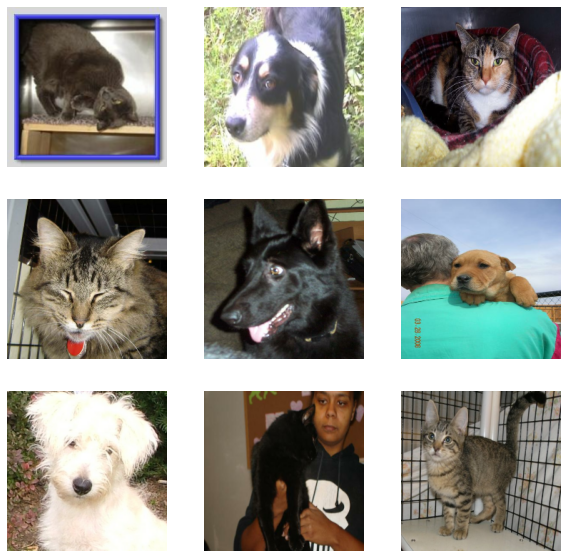

In [22]:
# Display 9 images from the dataset
def display_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.axis("off")
    plt.show()

# Display images from the training dataset
display_images(train_ds)


In [23]:
# Example of accessing a batch of data
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: (32, 224, 224, 3)
Batch of labels shape: (32,)


### 이진 분류 모델을 위해 출력층 수정 및 컴파일

In [24]:
# def modify_and_compile_model(model, num_classes, learning_rate=0.001):
#     model.layers.pop()  # 기존 출력층 제거
#     outputs = tf.keras.layers.Dense(num_classes)(model.layers[-1].output)
#     model = tf.keras.Model(inputs=model.input, outputs=outputs)

#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=['accuracy']
#     )
#     return model

In [25]:
# 기존 레이어를 제거하지 않고 좀 더 안전한 방법
def safety_modify_and_compile_model(model, num_classes, learning_rate=0.001):
    outputs = tf.keras.layers.Dense(num_classes)(model.layers[-2].output)
    model = tf.keras.Model(inputs=model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [26]:
def plot_metrics(history, model_name):
    """모델의 훈련 및 검증 손실과 정확도를 하나의 행에 그리기"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 손실 그래프 (훈련 + 검증)
    axes[0].plot(history.history['loss'], label=f'{model_name} (Train)')
    axes[0].plot(history.history['val_loss'], label=f'{model_name} (Validation)')
    axes[0].set_title(f'{model_name} Loss (Train & Validation)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # 정확도 그래프 (훈련 + 검증)
    axes[1].plot(history.history['accuracy'], label=f'{model_name} (Train)')
    axes[1].plot(history.history['val_accuracy'], label=f'{model_name} (Validation)')
    axes[1].set_title(f'{model_name} Accuracy (Train & Validation)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

### 모델 별 학습


- 리뷰 완료 후 추가 실험 진행
1. PlainNet-50 과 34 를 epochs = 50 과 callback 을 사용하지 않고 충분히 학습시켜 오버피팅 현상이나 깊은 레이어에서 학습이 안되는 현상을 관찰 하기 위해 먼저 시행함

2. modify_and_compile_model 함수가 정상 동작 안 됨을 확인(마지막 dense layer 가 삭제가 안 되고 append 됨)
- 학습에 큰 영향이 있을지는 모르겠으나 safety_modify_and_compile_model 으로 대체  

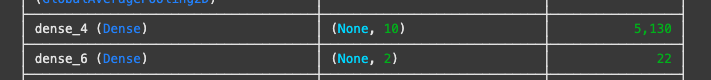

3. safety_modify_and_compile_model 함수 정상 동작 확인

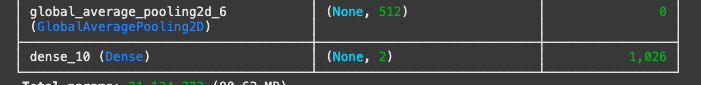

In [27]:
plainnet_34 = safety_modify_and_compile_model(plainnet_34, num_classes)
plainnet_34.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_178 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_178 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_164 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_179 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_179 (Bat (None, 56, 56, 64)        256 

In [28]:
print("\nPlainNet-34 학습 중...")
plainnet34_history = plainnet_34.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    verbose=1,
    # callbacks=callbacks
)


PlainNet-34 학습 중...
Epoch 1/50
165/582 [=======>......................] - ETA: 1:08 - loss: 0.7725 - accuracy: 0.5119

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:03 - loss: 0.7591 - accuracy: 0.5175

208/582 [=========>....................] - ETA: 1:01 - loss: 0.7566 - accuracy: 0.5180

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 50s - loss: 0.7432 - accuracy: 0.5211

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.7247 - accuracy: 0.5126

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.7241 - accuracy: 0.5127

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.7237 - accuracy: 0.5122

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.7232 - accuracy: 0.5109

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.7228 - accuracy: 0.5108

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7221 - accuracy: 0.5098

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 115s 184ms/step - loss: 0.7221 - accuracy: 0.5098 - val_loss: 0.7948 - val_accuracy: 0.4815
Epoch 2/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6989 - accuracy: 0.5085

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6998 - accuracy: 0.5125

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6990 - accuracy: 0.5129

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6988 - accuracy: 0.5145

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6976 - accuracy: 0.5144

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6976 - accuracy: 0.5150

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6972 - accuracy: 0.5160

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6966 - accuracy: 0.5181

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6965 - accuracy: 0.5182

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.5188

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.6962 - accuracy: 0.5188 - val_loss: 0.6945 - val_accuracy: 0.5099
Epoch 3/50
165/582 [=======>......................] - ETA: 1:11 - loss: 0.6991 - accuracy: 0.5100

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6990 - accuracy: 0.5095

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6991 - accuracy: 0.5092

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6986 - accuracy: 0.5092

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6973 - accuracy: 0.5079

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6971 - accuracy: 0.5082

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6971 - accuracy: 0.5078

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6969 - accuracy: 0.5095

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6969 - accuracy: 0.5092

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.5076

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6968 - accuracy: 0.5076 - val_loss: 0.7057 - val_accuracy: 0.4959
Epoch 4/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6953 - accuracy: 0.5021

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6953 - accuracy: 0.5014

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6956 - accuracy: 0.5011

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6955 - accuracy: 0.5058

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6926 - accuracy: 0.5120

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6921 - accuracy: 0.5138

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6923 - accuracy: 0.5138

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6919 - accuracy: 0.5154

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6918 - accuracy: 0.5150

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5146

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6919 - accuracy: 0.5146 - val_loss: 0.6930 - val_accuracy: 0.5512
Epoch 5/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6866 - accuracy: 0.5354

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6878 - accuracy: 0.5330

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6882 - accuracy: 0.5325

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6893 - accuracy: 0.5363

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6899 - accuracy: 0.5357

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6894 - accuracy: 0.5365

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6892 - accuracy: 0.5374

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6888 - accuracy: 0.5374

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6890 - accuracy: 0.5378

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5381

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6890 - accuracy: 0.5381 - val_loss: 0.6956 - val_accuracy: 0.5630
Epoch 6/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6869 - accuracy: 0.5466

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6877 - accuracy: 0.5459

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6875 - accuracy: 0.5472

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6858 - accuracy: 0.5515

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6874 - accuracy: 0.5407

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6877 - accuracy: 0.5398

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6877 - accuracy: 0.5399

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6881 - accuracy: 0.5381

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6882 - accuracy: 0.5383

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5370

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 110s 187ms/step - loss: 0.6883 - accuracy: 0.5370 - val_loss: 0.6948 - val_accuracy: 0.4901
Epoch 7/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6907 - accuracy: 0.5233

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6924 - accuracy: 0.5177

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6926 - accuracy: 0.5167

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6936 - accuracy: 0.5214

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6932 - accuracy: 0.5245

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6934 - accuracy: 0.5238

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6933 - accuracy: 0.5237

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6931 - accuracy: 0.5249

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6931 - accuracy: 0.5247

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5265

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6929 - accuracy: 0.5265 - val_loss: 0.7955 - val_accuracy: 0.5488
Epoch 8/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6898 - accuracy: 0.5375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6891 - accuracy: 0.5428

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6882 - accuracy: 0.5452

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6865 - accuracy: 0.5490

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6862 - accuracy: 0.5498

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6859 - accuracy: 0.5510

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6857 - accuracy: 0.5521

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6855 - accuracy: 0.5532

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6857 - accuracy: 0.5532

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5548

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6853 - accuracy: 0.5548 - val_loss: 0.7141 - val_accuracy: 0.4753
Epoch 9/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6927 - accuracy: 0.5282

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6923 - accuracy: 0.5309

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6925 - accuracy: 0.5306

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6926 - accuracy: 0.5311

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6919 - accuracy: 0.5326

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6918 - accuracy: 0.5331

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6915 - accuracy: 0.5338

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6909 - accuracy: 0.5361

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6907 - accuracy: 0.5366

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.5376

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6901 - accuracy: 0.5376 - val_loss: 0.7002 - val_accuracy: 0.5333
Epoch 10/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6883 - accuracy: 0.5434

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6880 - accuracy: 0.5432

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6882 - accuracy: 0.5428

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6847 - accuracy: 0.5471

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6810 - accuracy: 0.5592

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6806 - accuracy: 0.5604

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6804 - accuracy: 0.5611

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6798 - accuracy: 0.5621

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6797 - accuracy: 0.5624

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.5618

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6791 - accuracy: 0.5618 - val_loss: 0.6706 - val_accuracy: 0.5671
Epoch 11/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6685 - accuracy: 0.5884

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6695 - accuracy: 0.5848

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6687 - accuracy: 0.5862

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6683 - accuracy: 0.5786

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6642 - accuracy: 0.5868

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6640 - accuracy: 0.5868

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6636 - accuracy: 0.5880

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6635 - accuracy: 0.5885

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6634 - accuracy: 0.5890

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.5891

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6637 - accuracy: 0.5891 - val_loss: 0.6529 - val_accuracy: 0.6028
Epoch 12/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6477 - accuracy: 0.6216

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.6434 - accuracy: 0.6269

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6445 - accuracy: 0.6268

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6427 - accuracy: 0.6301

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6421 - accuracy: 0.6327

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6422 - accuracy: 0.6324

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6422 - accuracy: 0.6323

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6410 - accuracy: 0.6333

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6409 - accuracy: 0.6335

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6418 - accuracy: 0.6326

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6418 - accuracy: 0.6326 - val_loss: 1.1767 - val_accuracy: 0.5434
Epoch 13/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6353 - accuracy: 0.6445

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6305 - accuracy: 0.6507

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6320 - accuracy: 0.6495

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6300 - accuracy: 0.6488

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6313 - accuracy: 0.6487

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6317 - accuracy: 0.6480

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6316 - accuracy: 0.6479

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6308 - accuracy: 0.6487

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6306 - accuracy: 0.6487

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6311 - accuracy: 0.6479

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6311 - accuracy: 0.6479 - val_loss: 0.7704 - val_accuracy: 0.5021
Epoch 14/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6194 - accuracy: 0.6616

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6185 - accuracy: 0.6635

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6170 - accuracy: 0.6653

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6170 - accuracy: 0.6656

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.6138 - accuracy: 0.6670

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.6139 - accuracy: 0.6669

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.6137 - accuracy: 0.6673

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6122 - accuracy: 0.6681

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6122 - accuracy: 0.6681

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6114 - accuracy: 0.6685

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.6114 - accuracy: 0.6685 - val_loss: 0.7556 - val_accuracy: 0.5505
Epoch 15/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.6051 - accuracy: 0.6765

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.6039 - accuracy: 0.6760

208/582 [=========>....................] - ETA: 1:03 - loss: 0.6013 - accuracy: 0.6780

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.6036 - accuracy: 0.6740

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5992 - accuracy: 0.6805

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5989 - accuracy: 0.6814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5984 - accuracy: 0.6819

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5972 - accuracy: 0.6832

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5964 - accuracy: 0.6841

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5957 - accuracy: 0.6844

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5957 - accuracy: 0.6844 - val_loss: 0.7291 - val_accuracy: 0.5785
Epoch 16/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5925 - accuracy: 0.6883

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5915 - accuracy: 0.6880

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5912 - accuracy: 0.6881

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5873 - accuracy: 0.6886

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5755 - accuracy: 0.7015

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5757 - accuracy: 0.7009

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5758 - accuracy: 0.7007

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5747 - accuracy: 0.7022

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5744 - accuracy: 0.7024

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.7024

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5741 - accuracy: 0.7024 - val_loss: 0.7958 - val_accuracy: 0.5527
Epoch 17/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5622 - accuracy: 0.7121

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.5633 - accuracy: 0.7134

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5630 - accuracy: 0.7133

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5568 - accuracy: 0.7184

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5549 - accuracy: 0.7210

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5547 - accuracy: 0.7213

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5538 - accuracy: 0.7221

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5534 - accuracy: 0.7223

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5531 - accuracy: 0.7222

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.7226

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.5531 - accuracy: 0.7226 - val_loss: 0.6656 - val_accuracy: 0.6322
Epoch 18/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.5232 - accuracy: 0.7437

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5296 - accuracy: 0.7390

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5281 - accuracy: 0.7416

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5291 - accuracy: 0.7420

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.5265 - accuracy: 0.7431

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5263 - accuracy: 0.7433

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5266 - accuracy: 0.7426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5254 - accuracy: 0.7426

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5248 - accuracy: 0.7428

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5240 - accuracy: 0.7435

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.5240 - accuracy: 0.7435 - val_loss: 0.9531 - val_accuracy: 0.5140
Epoch 19/50
165/582 [=======>......................] - ETA: 1:11 - loss: 0.5114 - accuracy: 0.7485

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.5074 - accuracy: 0.7502

208/582 [=========>....................] - ETA: 1:03 - loss: 0.5082 - accuracy: 0.7497

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.5091 - accuracy: 0.7487

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.5050 - accuracy: 0.7563

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.5054 - accuracy: 0.7561

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.5059 - accuracy: 0.7559

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5032 - accuracy: 0.7580

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5033 - accuracy: 0.7578

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.7575

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.5032 - accuracy: 0.7575 - val_loss: 0.8009 - val_accuracy: 0.6180
Epoch 20/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.4816 - accuracy: 0.7746

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.4811 - accuracy: 0.7734

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4806 - accuracy: 0.7737

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4806 - accuracy: 0.7753

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.4737 - accuracy: 0.7818

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4734 - accuracy: 0.7822

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4721 - accuracy: 0.7829

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4721 - accuracy: 0.7832

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4722 - accuracy: 0.7829

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4721 - accuracy: 0.7828

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.4721 - accuracy: 0.7828 - val_loss: 0.7971 - val_accuracy: 0.6113
Epoch 21/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.4436 - accuracy: 0.7975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.4412 - accuracy: 0.7988

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4435 - accuracy: 0.7979

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4380 - accuracy: 0.8000

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.4357 - accuracy: 0.8032

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4368 - accuracy: 0.8021

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4363 - accuracy: 0.8018

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4347 - accuracy: 0.8028

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4345 - accuracy: 0.8028

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.8049

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.4309 - accuracy: 0.8049 - val_loss: 0.8842 - val_accuracy: 0.6419
Epoch 22/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.4088 - accuracy: 0.8227

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.4112 - accuracy: 0.8217

208/582 [=========>....................] - ETA: 1:03 - loss: 0.4106 - accuracy: 0.8215

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.4080 - accuracy: 0.8211

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.4037 - accuracy: 0.8228

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.4028 - accuracy: 0.8235

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.4031 - accuracy: 0.8232

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4001 - accuracy: 0.8248

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4004 - accuracy: 0.8248

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.8244

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.4005 - accuracy: 0.8244 - val_loss: 0.8758 - val_accuracy: 0.6434
Epoch 23/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.3886 - accuracy: 0.8320

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3838 - accuracy: 0.8329

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3854 - accuracy: 0.8322

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3782 - accuracy: 0.8365

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3756 - accuracy: 0.8361

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3756 - accuracy: 0.8361

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3756 - accuracy: 0.8364

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3726 - accuracy: 0.8381

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3718 - accuracy: 0.8385

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.8379

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.3727 - accuracy: 0.8379 - val_loss: 0.7351 - val_accuracy: 0.6900
Epoch 24/50
165/582 [=======>......................] - ETA: 1:11 - loss: 0.3443 - accuracy: 0.8525

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3479 - accuracy: 0.8490

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3477 - accuracy: 0.8484

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3479 - accuracy: 0.8503

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3448 - accuracy: 0.8531

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3451 - accuracy: 0.8527

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3455 - accuracy: 0.8525

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3447 - accuracy: 0.8530

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3452 - accuracy: 0.8529

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3442 - accuracy: 0.8533

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.3442 - accuracy: 0.8533 - val_loss: 0.3790 - val_accuracy: 0.8280
Epoch 25/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.3338 - accuracy: 0.8536

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3339 - accuracy: 0.8548

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3344 - accuracy: 0.8543

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3303 - accuracy: 0.8578

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.3270 - accuracy: 0.8599

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3257 - accuracy: 0.8608

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3255 - accuracy: 0.8609

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3255 - accuracy: 0.8609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3249 - accuracy: 0.8612

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3244 - accuracy: 0.8621

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.3244 - accuracy: 0.8621 - val_loss: 0.4374 - val_accuracy: 0.8104
Epoch 26/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.3033 - accuracy: 0.8723

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.3060 - accuracy: 0.8717

208/582 [=========>....................] - ETA: 1:03 - loss: 0.3057 - accuracy: 0.8727

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.3083 - accuracy: 0.8718

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.3033 - accuracy: 0.8731

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.3029 - accuracy: 0.8731

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.3024 - accuracy: 0.8734

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3022 - accuracy: 0.8730

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3030 - accuracy: 0.8727

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.3018 - accuracy: 0.8737 - val_loss: 0.3896 - val_accuracy: 0.8321
Epoch 27/50
165/582 [=======>......................] - ETA: 1:11 - loss: 0.2898 - accuracy: 0.8773

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2947 - accuracy: 0.8747

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2942 - accuracy: 0.8756

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2907 - accuracy: 0.8768

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.2853 - accuracy: 0.8810

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2843 - accuracy: 0.8817

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2849 - accuracy: 0.8812

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2845 - accuracy: 0.8813

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2840 - accuracy: 0.8815

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.8817

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 108s 183ms/step - loss: 0.2828 - accuracy: 0.8817 - val_loss: 0.3706 - val_accuracy: 0.8343
Epoch 28/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2750 - accuracy: 0.8831

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2732 - accuracy: 0.8819

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2765 - accuracy: 0.8803

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2743 - accuracy: 0.8817

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2677 - accuracy: 0.8865

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2676 - accuracy: 0.8868

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2680 - accuracy: 0.8868

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2663 - accuracy: 0.8876

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2667 - accuracy: 0.8873

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2656 - accuracy: 0.8884

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.2656 - accuracy: 0.8884 - val_loss: 0.4048 - val_accuracy: 0.8298
Epoch 29/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2562 - accuracy: 0.8888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2568 - accuracy: 0.8892

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2550 - accuracy: 0.8908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2591 - accuracy: 0.8881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2571 - accuracy: 0.8914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2566 - accuracy: 0.8916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2577 - accuracy: 0.8909

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2567 - accuracy: 0.8912

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2561 - accuracy: 0.8915

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.8929

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.2533 - accuracy: 0.8929 - val_loss: 1.2045 - val_accuracy: 0.6593
Epoch 30/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2469 - accuracy: 0.8955

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2418 - accuracy: 0.8982

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2421 - accuracy: 0.8977

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2433 - accuracy: 0.8984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2390 - accuracy: 0.9018

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2382 - accuracy: 0.9020

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2374 - accuracy: 0.9023

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2353 - accuracy: 0.9031

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2357 - accuracy: 0.9028

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2342 - accuracy: 0.9035

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.2342 - accuracy: 0.9035 - val_loss: 0.2768 - val_accuracy: 0.8895
Epoch 31/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2170 - accuracy: 0.9097

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2171 - accuracy: 0.9099

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2174 - accuracy: 0.9099

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2155 - accuracy: 0.9106

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2143 - accuracy: 0.9127

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2139 - accuracy: 0.9134

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2135 - accuracy: 0.9139

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2133 - accuracy: 0.9134

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2135 - accuracy: 0.9132

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9139

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.2125 - accuracy: 0.9139 - val_loss: 0.2638 - val_accuracy: 0.8897
Epoch 32/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.2178 - accuracy: 0.9106

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.2140 - accuracy: 0.9118

208/582 [=========>....................] - ETA: 1:03 - loss: 0.2132 - accuracy: 0.9118

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.2092 - accuracy: 0.9142

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.2053 - accuracy: 0.9171

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.2054 - accuracy: 0.9170

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.2046 - accuracy: 0.9173

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2024 - accuracy: 0.9183

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2024 - accuracy: 0.9182

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2013 - accuracy: 0.9185

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.2013 - accuracy: 0.9185 - val_loss: 1.0027 - val_accuracy: 0.5987
Epoch 33/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1996 - accuracy: 0.9244

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1960 - accuracy: 0.9238

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1953 - accuracy: 0.9238

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1975 - accuracy: 0.9219

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1900 - accuracy: 0.9240

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1902 - accuracy: 0.9237

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1896 - accuracy: 0.9241

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1887 - accuracy: 0.9240

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1881 - accuracy: 0.9244

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9246

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.1882 - accuracy: 0.9246 - val_loss: 0.2775 - val_accuracy: 0.8887
Epoch 34/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1977 - accuracy: 0.9167

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1954 - accuracy: 0.9200

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1981 - accuracy: 0.9189

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1954 - accuracy: 0.9203

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1866 - accuracy: 0.9248

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1858 - accuracy: 0.9252

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1854 - accuracy: 0.9254

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1830 - accuracy: 0.9265

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1830 - accuracy: 0.9263

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9267

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.1822 - accuracy: 0.9267 - val_loss: 0.2564 - val_accuracy: 0.8953
Epoch 35/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1749 - accuracy: 0.9318

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1779 - accuracy: 0.9310

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1775 - accuracy: 0.9313

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1728 - accuracy: 0.9326

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1728 - accuracy: 0.9329

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1733 - accuracy: 0.9326

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1735 - accuracy: 0.9321

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1720 - accuracy: 0.9330

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1714 - accuracy: 0.9333

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9337

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1696 - accuracy: 0.9337 - val_loss: 0.2772 - val_accuracy: 0.8887
Epoch 36/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1603 - accuracy: 0.9354

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1608 - accuracy: 0.9348

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1605 - accuracy: 0.9354

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1625 - accuracy: 0.9347

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1569 - accuracy: 0.9372

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1571 - accuracy: 0.9371

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1587 - accuracy: 0.9365

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1574 - accuracy: 0.9370

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1572 - accuracy: 0.9370

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9367

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.1573 - accuracy: 0.9367 - val_loss: 0.3551 - val_accuracy: 0.8605
Epoch 37/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1555 - accuracy: 0.9375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1609 - accuracy: 0.9356

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1604 - accuracy: 0.9354

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1560 - accuracy: 0.9382

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1524 - accuracy: 0.9393

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1521 - accuracy: 0.9394

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1514 - accuracy: 0.9398

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1518 - accuracy: 0.9397

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1520 - accuracy: 0.9396

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9404

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 183ms/step - loss: 0.1509 - accuracy: 0.9404 - val_loss: 0.2670 - val_accuracy: 0.9033
Epoch 38/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1448 - accuracy: 0.9390

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1455 - accuracy: 0.9402

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1457 - accuracy: 0.9401

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1414 - accuracy: 0.9427

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1411 - accuracy: 0.9435

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1410 - accuracy: 0.9436

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1409 - accuracy: 0.9437

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1389 - accuracy: 0.9448

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1389 - accuracy: 0.9447

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9456

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 110s 187ms/step - loss: 0.1374 - accuracy: 0.9456 - val_loss: 0.2815 - val_accuracy: 0.8921
Epoch 39/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1407 - accuracy: 0.9441

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1412 - accuracy: 0.9440

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1400 - accuracy: 0.9447

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1342 - accuracy: 0.9477

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1318 - accuracy: 0.9489

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1316 - accuracy: 0.9490

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1311 - accuracy: 0.9492

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1301 - accuracy: 0.9497

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1303 - accuracy: 0.9497

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1309 - accuracy: 0.9493

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1309 - accuracy: 0.9493 - val_loss: 0.2962 - val_accuracy: 0.8893
Epoch 40/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1345 - accuracy: 0.9481

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1326 - accuracy: 0.9484

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1301 - accuracy: 0.9494

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1327 - accuracy: 0.9488

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1271 - accuracy: 0.9512

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1276 - accuracy: 0.9510

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1264 - accuracy: 0.9515

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1242 - accuracy: 0.9524

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1242 - accuracy: 0.9524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9520

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1247 - accuracy: 0.9520 - val_loss: 0.3461 - val_accuracy: 0.8788
Epoch 41/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1241 - accuracy: 0.9532

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1300 - accuracy: 0.9504

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1288 - accuracy: 0.9515

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1234 - accuracy: 0.9526

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1158 - accuracy: 0.9553

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1155 - accuracy: 0.9553

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1153 - accuracy: 0.9554

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1141 - accuracy: 0.9561

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1146 - accuracy: 0.9559

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9557

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1154 - accuracy: 0.9557 - val_loss: 0.3057 - val_accuracy: 0.8777
Epoch 42/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1039 - accuracy: 0.9634

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1078 - accuracy: 0.9620

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1075 - accuracy: 0.9617

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1057 - accuracy: 0.9600

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1037 - accuracy: 0.9602

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1040 - accuracy: 0.9601

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1040 - accuracy: 0.9599

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1036 - accuracy: 0.9602

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1032 - accuracy: 0.9606

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9609

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1021 - accuracy: 0.9609 - val_loss: 0.6956 - val_accuracy: 0.7599
Epoch 43/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1069 - accuracy: 0.9555

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.1055 - accuracy: 0.9569

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1064 - accuracy: 0.9566

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1082 - accuracy: 0.9567

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1059 - accuracy: 0.9579

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1060 - accuracy: 0.9578

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1062 - accuracy: 0.9576

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1062 - accuracy: 0.9577

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1057 - accuracy: 0.9579

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9586

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.1042 - accuracy: 0.9586 - val_loss: 0.3227 - val_accuracy: 0.8895
Epoch 44/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1056 - accuracy: 0.9583

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1072 - accuracy: 0.9580

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1082 - accuracy: 0.9576

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1091 - accuracy: 0.9571

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.1024 - accuracy: 0.9608

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.1020 - accuracy: 0.9610

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.1024 - accuracy: 0.9607

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1010 - accuracy: 0.9613

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1007 - accuracy: 0.9614

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9617

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0999 - accuracy: 0.9617 - val_loss: 0.8817 - val_accuracy: 0.7969
Epoch 45/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1049 - accuracy: 0.9574

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.1066 - accuracy: 0.9563

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1055 - accuracy: 0.9572

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.1036 - accuracy: 0.9587

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0983 - accuracy: 0.9610

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0982 - accuracy: 0.9609

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0974 - accuracy: 0.9614

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0963 - accuracy: 0.9620

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0965 - accuracy: 0.9619

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9624

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0950 - accuracy: 0.9624 - val_loss: 0.3569 - val_accuracy: 0.8704
Epoch 46/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1010 - accuracy: 0.9621

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.0993 - accuracy: 0.9623

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0982 - accuracy: 0.9629

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0963 - accuracy: 0.9643

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0932 - accuracy: 0.9654

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0935 - accuracy: 0.9651

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0934 - accuracy: 0.9651

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0926 - accuracy: 0.9653

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0920 - accuracy: 0.9655

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9664

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0895 - accuracy: 0.9664 - val_loss: 0.3105 - val_accuracy: 0.8975
Epoch 47/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.1033 - accuracy: 0.9612

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.1014 - accuracy: 0.9615

208/582 [=========>....................] - ETA: 1:03 - loss: 0.1010 - accuracy: 0.9615

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0902 - accuracy: 0.9666

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0878 - accuracy: 0.9682

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0869 - accuracy: 0.9685

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0866 - accuracy: 0.9687

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0844 - accuracy: 0.9693

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0839 - accuracy: 0.9695

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9697

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0828 - accuracy: 0.9697 - val_loss: 0.4593 - val_accuracy: 0.8680
Epoch 48/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0771 - accuracy: 0.9705

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:05 - loss: 0.0773 - accuracy: 0.9713

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0768 - accuracy: 0.9718

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0818 - accuracy: 0.9698

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0838 - accuracy: 0.9684

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0837 - accuracy: 0.9684

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0833 - accuracy: 0.9684

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0822 - accuracy: 0.9693

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0820 - accuracy: 0.9693

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9697

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0814 - accuracy: 0.9697 - val_loss: 0.4169 - val_accuracy: 0.8454
Epoch 49/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0659 - accuracy: 0.9758

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.0725 - accuracy: 0.9722

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0727 - accuracy: 0.9725

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0760 - accuracy: 0.9720

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0739 - accuracy: 0.9722

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0739 - accuracy: 0.9721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0735 - accuracy: 0.9723

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0723 - accuracy: 0.9726

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0729 - accuracy: 0.9724

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9724

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0725 - accuracy: 0.9724 - val_loss: 0.3271 - val_accuracy: 0.8949
Epoch 50/50
165/582 [=======>......................] - ETA: 1:10 - loss: 0.0614 - accuracy: 0.9744

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:04 - loss: 0.0681 - accuracy: 0.9722

208/582 [=========>....................] - ETA: 1:03 - loss: 0.0681 - accuracy: 0.9721

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 51s - loss: 0.0683 - accuracy: 0.9728

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 15s - loss: 0.0700 - accuracy: 0.9723

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 13s - loss: 0.0702 - accuracy: 0.9722

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 11s - loss: 0.0701 - accuracy: 0.9724

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0690 - accuracy: 0.9728

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0686 - accuracy: 0.9729

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9720

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 107s 182ms/step - loss: 0.0707 - accuracy: 0.9720 - val_loss: 1.2620 - val_accuracy: 0.7248



PlainNet-34


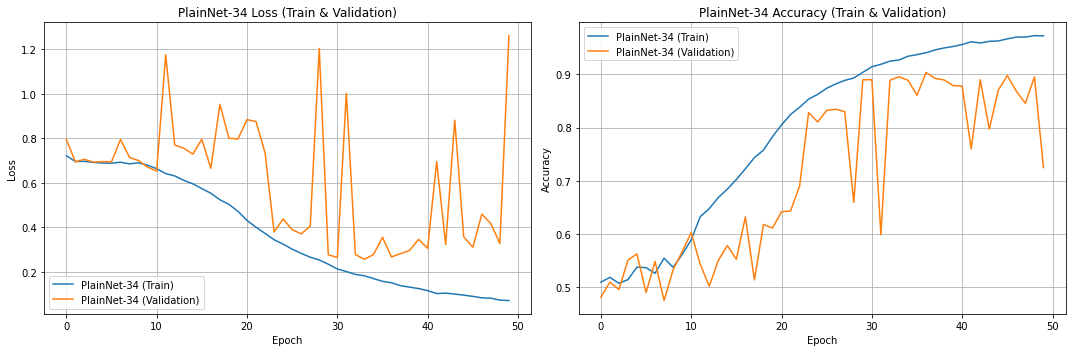

In [29]:
print("\nPlainNet-34")
plot_metrics(plainnet34_history, 'PlainNet-34')

In [30]:
plainnet_50 = safety_modify_and_compile_model(plainnet_50, num_classes)
plainnet_50.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_211 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
re_lu_197 (ReLU)             (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_212 (Bat (None, 56, 56, 64)        256 

In [31]:
print("\nPlainNet-50 학습 중...")
plainnet50_history = plainnet_50.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    verbose=1,
    # callbacks=callbacks
)


PlainNet-50 학습 중...
Epoch 1/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.7526 - accuracy: 0.4992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.7470 - accuracy: 0.5008

207/582 [=========>....................] - ETA: 1:55 - loss: 0.7477 - accuracy: 0.5012

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.7392 - accuracy: 0.5003

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.7276 - accuracy: 0.5074

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.7273 - accuracy: 0.5073

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.7263 - accuracy: 0.5071

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.7245 - accuracy: 0.5092

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.7239 - accuracy: 0.5102

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7215 - accuracy: 0.5121

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 201s 333ms/step - loss: 0.7215 - accuracy: 0.5121 - val_loss: 1.1804 - val_accuracy: 0.4897
Epoch 2/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6956 - accuracy: 0.5419

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6930 - accuracy: 0.5485

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6927 - accuracy: 0.5497

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6907 - accuracy: 0.5502

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6938 - accuracy: 0.5359

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6939 - accuracy: 0.5356

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6938 - accuracy: 0.5352

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6933 - accuracy: 0.5372

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6934 - accuracy: 0.5370

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5381

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 342ms/step - loss: 0.6932 - accuracy: 0.5381 - val_loss: 0.7613 - val_accuracy: 0.4985
Epoch 3/50
164/582 [=======>......................] - ETA: 2:09 - loss: 0.6888 - accuracy: 0.5604

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6886 - accuracy: 0.5612

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6895 - accuracy: 0.5562

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.6899 - accuracy: 0.5522

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6865 - accuracy: 0.5577

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6863 - accuracy: 0.5585

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6858 - accuracy: 0.5592

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6857 - accuracy: 0.5592

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6855 - accuracy: 0.5600

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.5620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 329ms/step - loss: 0.6846 - accuracy: 0.5620 - val_loss: 2.4546 - val_accuracy: 0.5217
Epoch 4/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6833 - accuracy: 0.5694

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6843 - accuracy: 0.5660

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6849 - accuracy: 0.5636

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.6861 - accuracy: 0.5586

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6907 - accuracy: 0.5394

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6910 - accuracy: 0.5388

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6915 - accuracy: 0.5379

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6918 - accuracy: 0.5366

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6919 - accuracy: 0.5356

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5340

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 329ms/step - loss: 0.6922 - accuracy: 0.5340 - val_loss: 0.7112 - val_accuracy: 0.5157
Epoch 5/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6881 - accuracy: 0.5604

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6883 - accuracy: 0.5576

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6882 - accuracy: 0.5572

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.6879 - accuracy: 0.5558

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6825 - accuracy: 0.5658

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6821 - accuracy: 0.5666

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6821 - accuracy: 0.5671

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6822 - accuracy: 0.5674

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6821 - accuracy: 0.5678

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6841 - accuracy: 0.5652

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6841 - accuracy: 0.5652 - val_loss: 2.2983 - val_accuracy: 0.4905
Epoch 6/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6906 - accuracy: 0.5465

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6899 - accuracy: 0.5504

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6902 - accuracy: 0.5491

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.6896 - accuracy: 0.5485

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6915 - accuracy: 0.5370

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6914 - accuracy: 0.5382

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6914 - accuracy: 0.5383

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6913 - accuracy: 0.5403

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6914 - accuracy: 0.5399

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5415

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6909 - accuracy: 0.5415 - val_loss: 0.7341 - val_accuracy: 0.4912
Epoch 7/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6875 - accuracy: 0.5554

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6886 - accuracy: 0.5531

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6897 - accuracy: 0.5516

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6916 - accuracy: 0.5409

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6933 - accuracy: 0.5300

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6931 - accuracy: 0.5282

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6932 - accuracy: 0.5284

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6931 - accuracy: 0.5287

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6927 - accuracy: 0.5284

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.5284

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6926 - accuracy: 0.5284 - val_loss: 1.3280 - val_accuracy: 0.5548
Epoch 8/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6877 - accuracy: 0.5541

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6884 - accuracy: 0.5558

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6875 - accuracy: 0.5605

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6836 - accuracy: 0.5670

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6768 - accuracy: 0.5814

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6766 - accuracy: 0.5816

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6756 - accuracy: 0.5832

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6748 - accuracy: 0.5849

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6752 - accuracy: 0.5843

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.5853

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6753 - accuracy: 0.5853 - val_loss: 0.7911 - val_accuracy: 0.5249
Epoch 9/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6816 - accuracy: 0.5694

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6852 - accuracy: 0.5589

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6854 - accuracy: 0.5587

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6860 - accuracy: 0.5591

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6856 - accuracy: 0.5554

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6852 - accuracy: 0.5564

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6849 - accuracy: 0.5574

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6847 - accuracy: 0.5583

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6847 - accuracy: 0.5584

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.5586

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6849 - accuracy: 0.5586 - val_loss: 0.7046 - val_accuracy: 0.4901
Epoch 10/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6878 - accuracy: 0.5579

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6896 - accuracy: 0.5535

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6888 - accuracy: 0.5553

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6876 - accuracy: 0.5553

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6873 - accuracy: 0.5537

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6868 - accuracy: 0.5546

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6867 - accuracy: 0.5545

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6868 - accuracy: 0.5544

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6867 - accuracy: 0.5546

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5554

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6864 - accuracy: 0.5554 - val_loss: 0.6941 - val_accuracy: 0.5303
Epoch 11/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6964 - accuracy: 0.5137

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6965 - accuracy: 0.5141

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6968 - accuracy: 0.5115

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6966 - accuracy: 0.5104

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6955 - accuracy: 0.5146

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6954 - accuracy: 0.5146

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6953 - accuracy: 0.5156

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6956 - accuracy: 0.5166

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6957 - accuracy: 0.5159

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5142

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6964 - accuracy: 0.5142 - val_loss: 0.6965 - val_accuracy: 0.4927
Epoch 12/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6922 - accuracy: 0.5307

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6927 - accuracy: 0.5311

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6929 - accuracy: 0.5303

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.6911 - accuracy: 0.5389

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6878 - accuracy: 0.5492

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6873 - accuracy: 0.5500

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6873 - accuracy: 0.5495

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6867 - accuracy: 0.5516

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6866 - accuracy: 0.5519

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5521

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6862 - accuracy: 0.5521 - val_loss: 0.6916 - val_accuracy: 0.5428
Epoch 13/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6799 - accuracy: 0.5703

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6817 - accuracy: 0.5669

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6824 - accuracy: 0.5661

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6841 - accuracy: 0.5627

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6860 - accuracy: 0.5601

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6860 - accuracy: 0.5604

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6859 - accuracy: 0.5611

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6856 - accuracy: 0.5609

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6855 - accuracy: 0.5615

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.5596

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6861 - accuracy: 0.5596 - val_loss: 0.7207 - val_accuracy: 0.5613
Epoch 14/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6893 - accuracy: 0.5259

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6895 - accuracy: 0.5276

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6898 - accuracy: 0.5266

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6890 - accuracy: 0.5319

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6870 - accuracy: 0.5429

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6866 - accuracy: 0.5444

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6868 - accuracy: 0.5447

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6868 - accuracy: 0.5443

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6871 - accuracy: 0.5443

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5444

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6875 - accuracy: 0.5444 - val_loss: 0.6959 - val_accuracy: 0.4899
Epoch 15/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6872 - accuracy: 0.5490

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6862 - accuracy: 0.5514

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6859 - accuracy: 0.5512

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6860 - accuracy: 0.5534

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6848 - accuracy: 0.5605

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6849 - accuracy: 0.5597

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6847 - accuracy: 0.5605

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6841 - accuracy: 0.5617

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6840 - accuracy: 0.5614

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5604

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6845 - accuracy: 0.5604 - val_loss: 0.7187 - val_accuracy: 0.5138
Epoch 16/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6793 - accuracy: 0.5724

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6801 - accuracy: 0.5693

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6796 - accuracy: 0.5707

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6819 - accuracy: 0.5673

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6844 - accuracy: 0.5609

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6846 - accuracy: 0.5601

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6847 - accuracy: 0.5599

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6851 - accuracy: 0.5588

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6851 - accuracy: 0.5590

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.5587

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6852 - accuracy: 0.5587 - val_loss: 1.0596 - val_accuracy: 0.5398
Epoch 17/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6913 - accuracy: 0.5474

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6937 - accuracy: 0.5433

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6936 - accuracy: 0.5420

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6941 - accuracy: 0.5346

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6933 - accuracy: 0.5338

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6930 - accuracy: 0.5348

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6928 - accuracy: 0.5359

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6922 - accuracy: 0.5384

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6922 - accuracy: 0.5385

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.5413

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 328ms/step - loss: 0.6912 - accuracy: 0.5413 - val_loss: 0.6993 - val_accuracy: 0.5258
Epoch 18/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6864 - accuracy: 0.5534

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6875 - accuracy: 0.5512

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6878 - accuracy: 0.5503

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6886 - accuracy: 0.5463

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 28s - loss: 0.6887 - accuracy: 0.5440

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6889 - accuracy: 0.5439

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6891 - accuracy: 0.5438

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6892 - accuracy: 0.5432

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6892 - accuracy: 0.5430

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5430

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6893 - accuracy: 0.5430 - val_loss: 0.6965 - val_accuracy: 0.5002
Epoch 19/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6853 - accuracy: 0.5528

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6853 - accuracy: 0.5535

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6852 - accuracy: 0.5542

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6848 - accuracy: 0.5521

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6820 - accuracy: 0.5640

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6816 - accuracy: 0.5652

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6816 - accuracy: 0.5651

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6809 - accuracy: 0.5669

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6810 - accuracy: 0.5669

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5659

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6817 - accuracy: 0.5659 - val_loss: 0.6917 - val_accuracy: 0.5449
Epoch 20/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6815 - accuracy: 0.5659

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6828 - accuracy: 0.5612

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6823 - accuracy: 0.5617

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6836 - accuracy: 0.5597

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6869 - accuracy: 0.5484

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6870 - accuracy: 0.5481

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6871 - accuracy: 0.5478

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6871 - accuracy: 0.5482

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6869 - accuracy: 0.5488

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.5464

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 199s 341ms/step - loss: 0.6876 - accuracy: 0.5464 - val_loss: 0.7476 - val_accuracy: 0.4901
Epoch 21/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6906 - accuracy: 0.5429

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6906 - accuracy: 0.5419

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6905 - accuracy: 0.5406

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6891 - accuracy: 0.5458

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6868 - accuracy: 0.5500

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6871 - accuracy: 0.5499

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6870 - accuracy: 0.5504

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6869 - accuracy: 0.5498

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6869 - accuracy: 0.5503

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.5488

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6874 - accuracy: 0.5488 - val_loss: 0.7058 - val_accuracy: 0.5239
Epoch 22/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6835 - accuracy: 0.5638

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6842 - accuracy: 0.5646

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6848 - accuracy: 0.5642

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6853 - accuracy: 0.5612

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6843 - accuracy: 0.5615

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6843 - accuracy: 0.5621

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6841 - accuracy: 0.5626

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6835 - accuracy: 0.5639

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6834 - accuracy: 0.5639

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.5646

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6832 - accuracy: 0.5646 - val_loss: 0.6848 - val_accuracy: 0.5572
Epoch 23/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6824 - accuracy: 0.5574

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6810 - accuracy: 0.5603

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6802 - accuracy: 0.5627

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6804 - accuracy: 0.5631

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6812 - accuracy: 0.5619

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6821 - accuracy: 0.5614

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6821 - accuracy: 0.5606

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6826 - accuracy: 0.5595

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6827 - accuracy: 0.5593

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.5579

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6833 - accuracy: 0.5579 - val_loss: 0.8949 - val_accuracy: 0.5052
Epoch 24/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6894 - accuracy: 0.5389

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6891 - accuracy: 0.5398

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6884 - accuracy: 0.5427

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6862 - accuracy: 0.5477

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6857 - accuracy: 0.5526

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6857 - accuracy: 0.5528

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6856 - accuracy: 0.5531

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6856 - accuracy: 0.5544

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6855 - accuracy: 0.5545

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5554

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6853 - accuracy: 0.5554 - val_loss: 0.6954 - val_accuracy: 0.5348
Epoch 25/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6866 - accuracy: 0.5541

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6850 - accuracy: 0.5604

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6851 - accuracy: 0.5601

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6841 - accuracy: 0.5619

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 28s - loss: 0.6841 - accuracy: 0.5626

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6845 - accuracy: 0.5622

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6842 - accuracy: 0.5630

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6836 - accuracy: 0.5648

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6837 - accuracy: 0.5647

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5667

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 191s 327ms/step - loss: 0.6829 - accuracy: 0.5667 - val_loss: 0.7300 - val_accuracy: 0.5840
Epoch 26/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6799 - accuracy: 0.5713

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6795 - accuracy: 0.5707

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6793 - accuracy: 0.5697

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6800 - accuracy: 0.5710

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6813 - accuracy: 0.5668

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6814 - accuracy: 0.5663

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6815 - accuracy: 0.5665

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6820 - accuracy: 0.5647

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6823 - accuracy: 0.5639

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6831 - accuracy: 0.5616

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6831 - accuracy: 0.5616 - val_loss: 0.7292 - val_accuracy: 0.4991
Epoch 27/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6920 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6921 - accuracy: 0.5316

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6917 - accuracy: 0.5335

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6911 - accuracy: 0.5358

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6902 - accuracy: 0.5382

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6902 - accuracy: 0.5389

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6897 - accuracy: 0.5408

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6896 - accuracy: 0.5407

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6895 - accuracy: 0.5407

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6890 - accuracy: 0.5437

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6890 - accuracy: 0.5437 - val_loss: 0.6816 - val_accuracy: 0.5679
Epoch 28/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6791 - accuracy: 0.5713

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6796 - accuracy: 0.5720

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6796 - accuracy: 0.5717

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6794 - accuracy: 0.5710

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6806 - accuracy: 0.5696

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6802 - accuracy: 0.5713

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6803 - accuracy: 0.5712

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6804 - accuracy: 0.5710

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6803 - accuracy: 0.5716

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.5737

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6792 - accuracy: 0.5737 - val_loss: 0.7277 - val_accuracy: 0.5105
Epoch 29/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6735 - accuracy: 0.5798

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6739 - accuracy: 0.5820

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6733 - accuracy: 0.5823

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6719 - accuracy: 0.5875

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6692 - accuracy: 0.5932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6694 - accuracy: 0.5927

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6692 - accuracy: 0.5928

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6690 - accuracy: 0.5937

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6684 - accuracy: 0.5943

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.5957

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6683 - accuracy: 0.5957 - val_loss: 0.6982 - val_accuracy: 0.5574
Epoch 30/50
164/582 [=======>......................] - ETA: 2:07 - loss: 0.6598 - accuracy: 0.6090

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6598 - accuracy: 0.6104

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6593 - accuracy: 0.6102

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6592 - accuracy: 0.6094

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6563 - accuracy: 0.6157

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6568 - accuracy: 0.6149

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6562 - accuracy: 0.6155

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6551 - accuracy: 0.6176

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6551 - accuracy: 0.6175

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.6181

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6549 - accuracy: 0.6181 - val_loss: 0.6620 - val_accuracy: 0.6238
Epoch 31/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6673 - accuracy: 0.5913

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6648 - accuracy: 0.5949

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6651 - accuracy: 0.5959

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6646 - accuracy: 0.6007

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6637 - accuracy: 0.6041

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6633 - accuracy: 0.6045

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6626 - accuracy: 0.6058

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6618 - accuracy: 0.6064

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6615 - accuracy: 0.6072

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.6085

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6605 - accuracy: 0.6085 - val_loss: 0.7034 - val_accuracy: 0.5664
Epoch 32/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6504 - accuracy: 0.6206

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6523 - accuracy: 0.6199

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6525 - accuracy: 0.6191

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6544 - accuracy: 0.6166

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6592 - accuracy: 0.6092

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6595 - accuracy: 0.6086

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6592 - accuracy: 0.6096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6588 - accuracy: 0.6099

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6587 - accuracy: 0.6099

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.6121

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6575 - accuracy: 0.6121 - val_loss: 0.9266 - val_accuracy: 0.5477
Epoch 33/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6489 - accuracy: 0.6227

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6470 - accuracy: 0.6245

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6469 - accuracy: 0.6259

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.6470 - accuracy: 0.6261

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6434 - accuracy: 0.6312

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6430 - accuracy: 0.6319

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6431 - accuracy: 0.6318

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6428 - accuracy: 0.6326

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6426 - accuracy: 0.6329

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.6347

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6412 - accuracy: 0.6347 - val_loss: 0.6730 - val_accuracy: 0.5929
Epoch 34/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6224 - accuracy: 0.6578

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:57 - loss: 0.6230 - accuracy: 0.6582

207/582 [=========>....................] - ETA: 1:54 - loss: 0.6236 - accuracy: 0.6578

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.6228 - accuracy: 0.6592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6192 - accuracy: 0.6617

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6196 - accuracy: 0.6619

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6187 - accuracy: 0.6632

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6188 - accuracy: 0.6632

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6189 - accuracy: 0.6630

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.6630

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6191 - accuracy: 0.6630 - val_loss: 0.6538 - val_accuracy: 0.6328
Epoch 35/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.6115 - accuracy: 0.6690

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.6112 - accuracy: 0.6712

207/582 [=========>....................] - ETA: 1:55 - loss: 0.6096 - accuracy: 0.6730

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.6045 - accuracy: 0.6774

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.6007 - accuracy: 0.6811

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.6004 - accuracy: 0.6814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.6005 - accuracy: 0.6813

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.6014 - accuracy: 0.6800

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.6014 - accuracy: 0.6801

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.6812

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.6001 - accuracy: 0.6812 - val_loss: 0.6420 - val_accuracy: 0.6518
Epoch 36/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.5969 - accuracy: 0.6871

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.5925 - accuracy: 0.6927

207/582 [=========>....................] - ETA: 1:55 - loss: 0.5908 - accuracy: 0.6947

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.5871 - accuracy: 0.6940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.5837 - accuracy: 0.6989

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.5834 - accuracy: 0.6988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.5838 - accuracy: 0.6992

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.5817 - accuracy: 0.7009

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.5816 - accuracy: 0.7013

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.7017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.5804 - accuracy: 0.7017 - val_loss: 0.6267 - val_accuracy: 0.6651
Epoch 37/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.5738 - accuracy: 0.7111

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.5718 - accuracy: 0.7118

207/582 [=========>....................] - ETA: 1:55 - loss: 0.5699 - accuracy: 0.7118

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.5676 - accuracy: 0.7116

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.5633 - accuracy: 0.7148

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.5631 - accuracy: 0.7152

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.5634 - accuracy: 0.7147

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.5617 - accuracy: 0.7161

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.5616 - accuracy: 0.7162

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7171

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 200s 343ms/step - loss: 0.5605 - accuracy: 0.7171 - val_loss: 0.6202 - val_accuracy: 0.6941
Epoch 38/50
164/582 [=======>......................] - ETA: 2:09 - loss: 0.5467 - accuracy: 0.7247

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.5482 - accuracy: 0.7246

207/582 [=========>....................] - ETA: 1:55 - loss: 0.5475 - accuracy: 0.7252

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.5445 - accuracy: 0.7273

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.5464 - accuracy: 0.7260

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.5455 - accuracy: 0.7267

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.5454 - accuracy: 0.7267

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.5451 - accuracy: 0.7269

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.5448 - accuracy: 0.7270

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7279

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 329ms/step - loss: 0.5436 - accuracy: 0.7279 - val_loss: 0.6177 - val_accuracy: 0.7066
Epoch 39/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.5303 - accuracy: 0.7382

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.5292 - accuracy: 0.7384

207/582 [=========>....................] - ETA: 1:55 - loss: 0.5286 - accuracy: 0.7381

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.5292 - accuracy: 0.7401

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.5235 - accuracy: 0.7427

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.5247 - accuracy: 0.7424

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.5252 - accuracy: 0.7417

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.5245 - accuracy: 0.7421

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.5232 - accuracy: 0.7426

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7429

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.5229 - accuracy: 0.7429 - val_loss: 0.5091 - val_accuracy: 0.7511
Epoch 40/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.5135 - accuracy: 0.7481

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.5112 - accuracy: 0.7503

207/582 [=========>....................] - ETA: 1:55 - loss: 0.5107 - accuracy: 0.7509

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.5083 - accuracy: 0.7548

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.5075 - accuracy: 0.7561

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.5075 - accuracy: 0.7562

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.5078 - accuracy: 0.7555

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.5083 - accuracy: 0.7552

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.5075 - accuracy: 0.7556

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5061 - accuracy: 0.7572

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.5061 - accuracy: 0.7572 - val_loss: 0.5075 - val_accuracy: 0.7483
Epoch 41/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.5027 - accuracy: 0.7565

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.5013 - accuracy: 0.7578

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4991 - accuracy: 0.7595

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.4992 - accuracy: 0.7604

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4960 - accuracy: 0.7648

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4960 - accuracy: 0.7646

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4962 - accuracy: 0.7641

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4960 - accuracy: 0.7644

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4956 - accuracy: 0.7649

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7650

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.4954 - accuracy: 0.7650 - val_loss: 0.9483 - val_accuracy: 0.5578
Epoch 42/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4967 - accuracy: 0.7639

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4978 - accuracy: 0.7641

207/582 [=========>....................] - ETA: 1:54 - loss: 0.4983 - accuracy: 0.7637

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:32 - loss: 0.4957 - accuracy: 0.7664

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4826 - accuracy: 0.7734

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4829 - accuracy: 0.7729

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4836 - accuracy: 0.7725

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4845 - accuracy: 0.7722

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4844 - accuracy: 0.7723

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4832 - accuracy: 0.7726

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 328ms/step - loss: 0.4832 - accuracy: 0.7726 - val_loss: 0.5769 - val_accuracy: 0.7248
Epoch 43/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4758 - accuracy: 0.7776

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4733 - accuracy: 0.7779

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4718 - accuracy: 0.7787

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.4684 - accuracy: 0.7806

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4650 - accuracy: 0.7862

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4642 - accuracy: 0.7864

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4642 - accuracy: 0.7861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4633 - accuracy: 0.7865

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4635 - accuracy: 0.7863

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.7873

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 329ms/step - loss: 0.4622 - accuracy: 0.7873 - val_loss: 0.7459 - val_accuracy: 0.6825
Epoch 44/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4609 - accuracy: 0.7898

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4557 - accuracy: 0.7927

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4559 - accuracy: 0.7938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.4566 - accuracy: 0.7916

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4500 - accuracy: 0.7948

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4516 - accuracy: 0.7939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4520 - accuracy: 0.7935

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4520 - accuracy: 0.7932

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4521 - accuracy: 0.7927

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.7933

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 192s 329ms/step - loss: 0.4510 - accuracy: 0.7933 - val_loss: 0.4794 - val_accuracy: 0.7779
Epoch 45/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4494 - accuracy: 0.7875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4541 - accuracy: 0.7865

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4540 - accuracy: 0.7867

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.4482 - accuracy: 0.7911

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4440 - accuracy: 0.7943

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4441 - accuracy: 0.7939

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4437 - accuracy: 0.7941

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4417 - accuracy: 0.7960

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4427 - accuracy: 0.7953

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.7956

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 329ms/step - loss: 0.4419 - accuracy: 0.7956 - val_loss: 0.5659 - val_accuracy: 0.7358
Epoch 46/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4297 - accuracy: 0.8014

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4307 - accuracy: 0.7993

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4303 - accuracy: 0.7994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.4292 - accuracy: 0.8029

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4254 - accuracy: 0.8070

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4262 - accuracy: 0.8067

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4269 - accuracy: 0.8065

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4279 - accuracy: 0.8055

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4280 - accuracy: 0.8056

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.8071

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 329ms/step - loss: 0.4258 - accuracy: 0.8071 - val_loss: 0.6262 - val_accuracy: 0.7270
Epoch 47/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4232 - accuracy: 0.8083

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4217 - accuracy: 0.8074

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4231 - accuracy: 0.8068

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.4226 - accuracy: 0.8063

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4214 - accuracy: 0.8097

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4202 - accuracy: 0.8104

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4196 - accuracy: 0.8108

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4203 - accuracy: 0.8098

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4212 - accuracy: 0.8096

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.8097

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 330ms/step - loss: 0.4221 - accuracy: 0.8097 - val_loss: 0.4391 - val_accuracy: 0.7982
Epoch 48/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4142 - accuracy: 0.8096

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4127 - accuracy: 0.8120

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4137 - accuracy: 0.8117

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.4141 - accuracy: 0.8122

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.4085 - accuracy: 0.8157

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.4068 - accuracy: 0.8165

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.4060 - accuracy: 0.8168

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.4059 - accuracy: 0.8170

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.4062 - accuracy: 0.8168

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4058 - accuracy: 0.8174

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 329ms/step - loss: 0.4058 - accuracy: 0.8174 - val_loss: 0.4577 - val_accuracy: 0.7833
Epoch 49/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.4035 - accuracy: 0.8169

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.4012 - accuracy: 0.8173

207/582 [=========>....................] - ETA: 1:55 - loss: 0.4010 - accuracy: 0.8175

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.3985 - accuracy: 0.8205

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.3960 - accuracy: 0.8246

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.3961 - accuracy: 0.8246

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.3967 - accuracy: 0.8241

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.3960 - accuracy: 0.8241

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.3965 - accuracy: 0.8235

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8229

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 329ms/step - loss: 0.3975 - accuracy: 0.8229 - val_loss: 0.4767 - val_accuracy: 0.8005
Epoch 50/50
164/582 [=======>......................] - ETA: 2:08 - loss: 0.3943 - accuracy: 0.8192

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 1:58 - loss: 0.3922 - accuracy: 0.8211

207/582 [=========>....................] - ETA: 1:55 - loss: 0.3943 - accuracy: 0.8210

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:33 - loss: 0.3899 - accuracy: 0.8250

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 29s - loss: 0.3871 - accuracy: 0.8264

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 25s - loss: 0.3874 - accuracy: 0.8263

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 21s - loss: 0.3871 - accuracy: 0.8263

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 13s - loss: 0.3859 - accuracy: 0.8268

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 11s - loss: 0.3851 - accuracy: 0.8271

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3842 - accuracy: 0.8282

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 193s 330ms/step - loss: 0.3842 - accuracy: 0.8282 - val_loss: 0.6312 - val_accuracy: 0.6986



PlainNet-50


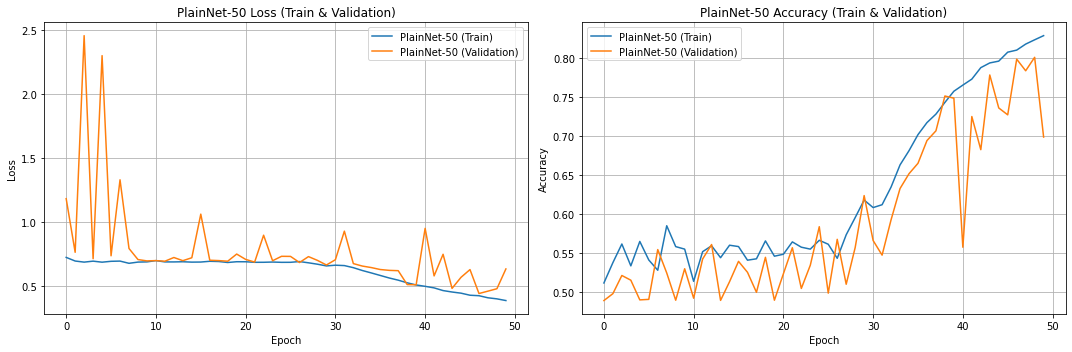

In [32]:
print("\nPlainNet-50")
plot_metrics(plainnet50_history, 'PlainNet-50')

In [33]:
EPOCH = 50

In [34]:
# 콜백 설정 - 현재 사용 안함
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

In [35]:
resnet_34 = safety_modify_and_compile_model(resnet_34, num_classes)
resnet_34.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 112, 112, 64) 256         conv2d_89[0][0]                  
__________________________________________________________________________________________________
re_lu_82 (ReLU)                 (None, 112, 112, 64) 0           batch_normalization_89[0][0]     
____________________________________________________________________________________________

In [36]:
print("\nResNet-34 학습 중...")
resnet34_history = resnet_34.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacks
)


ResNet-34 학습 중...
Epoch 1/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.7764 - accuracy: 0.5695

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.7624 - accuracy: 0.5680

208/582 [=========>....................] - ETA: 1:06 - loss: 0.7602 - accuracy: 0.5691

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.7422 - accuracy: 0.5738

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.7176 - accuracy: 0.5786

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.7162 - accuracy: 0.5782

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.7150 - accuracy: 0.5789

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.7121 - accuracy: 0.5806

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.7116 - accuracy: 0.5813

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7099 - accuracy: 0.5822

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 117s 193ms/step - loss: 0.7099 - accuracy: 0.5822 - val_loss: 1.5876 - val_accuracy: 0.5056
Epoch 2/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.6700 - accuracy: 0.6085

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.6707 - accuracy: 0.6043

208/582 [=========>....................] - ETA: 1:07 - loss: 0.6700 - accuracy: 0.6043

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.6673 - accuracy: 0.6065

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.6629 - accuracy: 0.6148

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.6612 - accuracy: 0.6167

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.6605 - accuracy: 0.6172

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6580 - accuracy: 0.6202

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6575 - accuracy: 0.6205

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.6232

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 115s 197ms/step - loss: 0.6546 - accuracy: 0.6232 - val_loss: 0.8237 - val_accuracy: 0.5712
Epoch 3/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.6163 - accuracy: 0.6631

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.6166 - accuracy: 0.6659

208/582 [=========>....................] - ETA: 1:06 - loss: 0.6179 - accuracy: 0.6638

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.6172 - accuracy: 0.6661

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.6085 - accuracy: 0.6762

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.6079 - accuracy: 0.6771

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.6072 - accuracy: 0.6778

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.6052 - accuracy: 0.6791

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.6057 - accuracy: 0.6790

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.6801

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.6034 - accuracy: 0.6801 - val_loss: 0.8871 - val_accuracy: 0.5798
Epoch 4/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.5654 - accuracy: 0.7178

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.5661 - accuracy: 0.7139

208/582 [=========>....................] - ETA: 1:06 - loss: 0.5670 - accuracy: 0.7130

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.5675 - accuracy: 0.7132

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.5643 - accuracy: 0.7154

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.5647 - accuracy: 0.7154

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.5639 - accuracy: 0.7160

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5608 - accuracy: 0.7179

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5606 - accuracy: 0.7182

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5615 - accuracy: 0.7172

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.5615 - accuracy: 0.7172 - val_loss: 0.7467 - val_accuracy: 0.6296
Epoch 5/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.5426 - accuracy: 0.7271

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.5434 - accuracy: 0.7252

208/582 [=========>....................] - ETA: 1:06 - loss: 0.5431 - accuracy: 0.7249

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.5411 - accuracy: 0.7266

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.5366 - accuracy: 0.7320

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.5367 - accuracy: 0.7315

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.5361 - accuracy: 0.7324

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5334 - accuracy: 0.7341

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5329 - accuracy: 0.7342

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5322 - accuracy: 0.7349

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 112s 191ms/step - loss: 0.5322 - accuracy: 0.7349 - val_loss: 0.8298 - val_accuracy: 0.5840
Epoch 6/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.5341 - accuracy: 0.7316

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.5300 - accuracy: 0.7336

208/582 [=========>....................] - ETA: 1:06 - loss: 0.5296 - accuracy: 0.7339

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.5172 - accuracy: 0.7434

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.5066 - accuracy: 0.7522

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.5054 - accuracy: 0.7536

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.5053 - accuracy: 0.7540

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.5025 - accuracy: 0.7558

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.5024 - accuracy: 0.7557

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5014 - accuracy: 0.7565

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.5014 - accuracy: 0.7565 - val_loss: 0.5015 - val_accuracy: 0.7638
Epoch 7/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.4879 - accuracy: 0.7672

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.4853 - accuracy: 0.7677

208/582 [=========>....................] - ETA: 1:06 - loss: 0.4846 - accuracy: 0.7686

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.4806 - accuracy: 0.7718

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.4706 - accuracy: 0.7763

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.4695 - accuracy: 0.7769

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.4703 - accuracy: 0.7769

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4687 - accuracy: 0.7787

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4683 - accuracy: 0.7790

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4667 - accuracy: 0.7801

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.4667 - accuracy: 0.7801 - val_loss: 1.0152 - val_accuracy: 0.6066
Epoch 8/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.4364 - accuracy: 0.8055

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.4383 - accuracy: 0.8033

208/582 [=========>....................] - ETA: 1:06 - loss: 0.4356 - accuracy: 0.8045

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.4344 - accuracy: 0.8051

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.4269 - accuracy: 0.8107

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.4256 - accuracy: 0.8118

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.4254 - accuracy: 0.8121

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.4233 - accuracy: 0.8126

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.4234 - accuracy: 0.8123

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8131

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.4211 - accuracy: 0.8131 - val_loss: 0.6357 - val_accuracy: 0.7034
Epoch 9/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.3669 - accuracy: 0.8294

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.3648 - accuracy: 0.8307

208/582 [=========>....................] - ETA: 1:06 - loss: 0.3622 - accuracy: 0.8329

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.3582 - accuracy: 0.8360

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.3469 - accuracy: 0.8442

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.3464 - accuracy: 0.8447

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.3457 - accuracy: 0.8452

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.3435 - accuracy: 0.8462

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.3427 - accuracy: 0.8468

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8466

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.3418 - accuracy: 0.8466 - val_loss: 0.4839 - val_accuracy: 0.7734
Epoch 10/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.2947 - accuracy: 0.8714

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.2902 - accuracy: 0.8734

208/582 [=========>....................] - ETA: 1:06 - loss: 0.2897 - accuracy: 0.8741

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.2821 - accuracy: 0.8788

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.2747 - accuracy: 0.8820

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.2740 - accuracy: 0.8823

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.2731 - accuracy: 0.8829

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2717 - accuracy: 0.8834

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2722 - accuracy: 0.8832

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2734 - accuracy: 0.8826

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.2734 - accuracy: 0.8826 - val_loss: 0.3516 - val_accuracy: 0.8435
Epoch 11/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.2384 - accuracy: 0.8996

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.2367 - accuracy: 0.9007

208/582 [=========>....................] - ETA: 1:06 - loss: 0.2386 - accuracy: 0.8999

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.2385 - accuracy: 0.9010

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.2355 - accuracy: 0.8995

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.2348 - accuracy: 0.8995

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.2337 - accuracy: 0.9002

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2335 - accuracy: 0.9002

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2341 - accuracy: 0.8999

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.2333 - accuracy: 0.9005 - val_loss: 0.5614 - val_accuracy: 0.7509
Epoch 12/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.2065 - accuracy: 0.9134

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.2114 - accuracy: 0.9130

208/582 [=========>....................] - ETA: 1:06 - loss: 0.2101 - accuracy: 0.9130

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.2069 - accuracy: 0.9136

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1998 - accuracy: 0.9184

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.2010 - accuracy: 0.9176

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.2008 - accuracy: 0.9179

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.2002 - accuracy: 0.9178

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.2005 - accuracy: 0.9177

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9184

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.1988 - accuracy: 0.9184 - val_loss: 0.2876 - val_accuracy: 0.8723
Epoch 13/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1678 - accuracy: 0.9322

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1660 - accuracy: 0.9326

208/582 [=========>....................] - ETA: 1:07 - loss: 0.1695 - accuracy: 0.9309

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.1678 - accuracy: 0.9317

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1696 - accuracy: 0.9315

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1700 - accuracy: 0.9316

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1702 - accuracy: 0.9315

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1681 - accuracy: 0.9322

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1690 - accuracy: 0.9318

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1704 - accuracy: 0.9304

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.1704 - accuracy: 0.9304 - val_loss: 0.6019 - val_accuracy: 0.7375
Epoch 14/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1531 - accuracy: 0.9392

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1532 - accuracy: 0.9391

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1507 - accuracy: 0.9407

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.1452 - accuracy: 0.9429

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1435 - accuracy: 0.9435

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1429 - accuracy: 0.9438

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1423 - accuracy: 0.9442

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1418 - accuracy: 0.9445

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1417 - accuracy: 0.9445

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1405 - accuracy: 0.9449

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.1405 - accuracy: 0.9449 - val_loss: 0.4476 - val_accuracy: 0.8267
Epoch 15/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1313 - accuracy: 0.9477

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1319 - accuracy: 0.9479

208/582 [=========>....................] - ETA: 1:07 - loss: 0.1318 - accuracy: 0.9477

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.1266 - accuracy: 0.9493

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1269 - accuracy: 0.9485

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1268 - accuracy: 0.9485

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1259 - accuracy: 0.9490

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.1248 - accuracy: 0.9493

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.1245 - accuracy: 0.9495

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9497

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.1235 - accuracy: 0.9497 - val_loss: 0.3215 - val_accuracy: 0.8659
Epoch 16/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.1019 - accuracy: 0.9581

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.1013 - accuracy: 0.9590

208/582 [=========>....................] - ETA: 1:06 - loss: 0.1007 - accuracy: 0.9596

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.1002 - accuracy: 0.9598

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.1005 - accuracy: 0.9604

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.1009 - accuracy: 0.9604

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.1006 - accuracy: 0.9606

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0991 - accuracy: 0.9614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0989 - accuracy: 0.9615

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0984 - accuracy: 0.9616

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0984 - accuracy: 0.9616 - val_loss: 0.3429 - val_accuracy: 0.8463
Epoch 17/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0901 - accuracy: 0.9619

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0840 - accuracy: 0.9653

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0825 - accuracy: 0.9660

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0881 - accuracy: 0.9644

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0876 - accuracy: 0.9654

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0868 - accuracy: 0.9658

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0864 - accuracy: 0.9660

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0865 - accuracy: 0.9659

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0864 - accuracy: 0.9661

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9663

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0859 - accuracy: 0.9663 - val_loss: 0.3723 - val_accuracy: 0.8837
Epoch 18/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0770 - accuracy: 0.9689

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0748 - accuracy: 0.9705

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0733 - accuracy: 0.9710

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0682 - accuracy: 0.9729

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0658 - accuracy: 0.9737

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0654 - accuracy: 0.9737

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0650 - accuracy: 0.9740

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0647 - accuracy: 0.9743

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0643 - accuracy: 0.9745

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9752

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0627 - accuracy: 0.9752 - val_loss: 0.2698 - val_accuracy: 0.9202
Epoch 19/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0668 - accuracy: 0.9733

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:09 - loss: 0.0694 - accuracy: 0.9724

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0680 - accuracy: 0.9728

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0616 - accuracy: 0.9759

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0585 - accuracy: 0.9773

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0579 - accuracy: 0.9777

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0588 - accuracy: 0.9774

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0581 - accuracy: 0.9776

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0579 - accuracy: 0.9776

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9780

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.0572 - accuracy: 0.9780 - val_loss: 0.3303 - val_accuracy: 0.8921
Epoch 20/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0456 - accuracy: 0.9826

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0442 - accuracy: 0.9830

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0455 - accuracy: 0.9824

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0487 - accuracy: 0.9815

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0523 - accuracy: 0.9801

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0527 - accuracy: 0.9801

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0527 - accuracy: 0.9802

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0525 - accuracy: 0.9801

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0523 - accuracy: 0.9802

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9804

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.0515 - accuracy: 0.9804 - val_loss: 0.4157 - val_accuracy: 0.8833
Epoch 21/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0320 - accuracy: 0.9875

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0328 - accuracy: 0.9867

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0320 - accuracy: 0.9869

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0310 - accuracy: 0.9881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0359 - accuracy: 0.9865

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0356 - accuracy: 0.9867

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0355 - accuracy: 0.9868

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0350 - accuracy: 0.9871

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0348 - accuracy: 0.9872

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0347 - accuracy: 0.9873

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.0347 - accuracy: 0.9873 - val_loss: 0.2637 - val_accuracy: 0.9282
Epoch 22/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0377 - accuracy: 0.9862

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0377 - accuracy: 0.9864

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0373 - accuracy: 0.9863

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0352 - accuracy: 0.9869

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0327 - accuracy: 0.9885

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0327 - accuracy: 0.9884

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0324 - accuracy: 0.9886

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0323 - accuracy: 0.9887

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0324 - accuracy: 0.9887

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9884

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0333 - accuracy: 0.9884 - val_loss: 0.6025 - val_accuracy: 0.8528
Epoch 23/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0394 - accuracy: 0.9847

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0390 - accuracy: 0.9847

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0395 - accuracy: 0.9847

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0365 - accuracy: 0.9862

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0341 - accuracy: 0.9878

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0343 - accuracy: 0.9878

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0349 - accuracy: 0.9874

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0342 - accuracy: 0.9878

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0343 - accuracy: 0.9878

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9882

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0334 - accuracy: 0.9882 - val_loss: 0.3168 - val_accuracy: 0.9185
Epoch 24/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0433 - accuracy: 0.9833

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0420 - accuracy: 0.9839

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0408 - accuracy: 0.9844

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0372 - accuracy: 0.9860

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0313 - accuracy: 0.9883

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0308 - accuracy: 0.9883

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0304 - accuracy: 0.9885

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0298 - accuracy: 0.9888

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0297 - accuracy: 0.9888

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9890

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0296 - accuracy: 0.9890 - val_loss: 0.3088 - val_accuracy: 0.9144
Epoch 25/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0232 - accuracy: 0.9930

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0232 - accuracy: 0.9935

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0232 - accuracy: 0.9934

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0269 - accuracy: 0.9921

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0324 - accuracy: 0.9898

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0321 - accuracy: 0.9898

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0322 - accuracy: 0.9898

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0316 - accuracy: 0.9899

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0315 - accuracy: 0.9899

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9902

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0304 - accuracy: 0.9902 - val_loss: 0.3294 - val_accuracy: 0.9086
Epoch 26/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0279 - accuracy: 0.9905

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0250 - accuracy: 0.9915

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0244 - accuracy: 0.9917

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0245 - accuracy: 0.9915

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0215 - accuracy: 0.9926

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0217 - accuracy: 0.9925

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0220 - accuracy: 0.9924

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0221 - accuracy: 0.9923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0221 - accuracy: 0.9924

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9926

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.4731 - val_accuracy: 0.9035
Epoch 27/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0252 - accuracy: 0.9917

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0260 - accuracy: 0.9912

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0255 - accuracy: 0.9914

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0256 - accuracy: 0.9913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0231 - accuracy: 0.9913

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0234 - accuracy: 0.9912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0232 - accuracy: 0.9913

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0231 - accuracy: 0.9914

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0230 - accuracy: 0.9915

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9907

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.0244 - accuracy: 0.9907 - val_loss: 1.0385 - val_accuracy: 0.8216
Epoch 28/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0338 - accuracy: 0.9867

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0309 - accuracy: 0.9880

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0300 - accuracy: 0.9884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0298 - accuracy: 0.9883

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0263 - accuracy: 0.9903

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0260 - accuracy: 0.9904

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0258 - accuracy: 0.9904

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0252 - accuracy: 0.9908

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0251 - accuracy: 0.9908

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9908

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0250 - accuracy: 0.9908 - val_loss: 0.3552 - val_accuracy: 0.9076
Epoch 29/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0227 - accuracy: 0.9920

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0221 - accuracy: 0.9923

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0228 - accuracy: 0.9922

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0221 - accuracy: 0.9923

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0194 - accuracy: 0.9937

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0192 - accuracy: 0.9936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0189 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0182 - accuracy: 0.9939

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0181 - accuracy: 0.9940

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0177 - accuracy: 0.9941 - val_loss: 0.3257 - val_accuracy: 0.9288
Epoch 30/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0175 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0225 - accuracy: 0.9927

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0230 - accuracy: 0.9925

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0237 - accuracy: 0.9922

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0202 - accuracy: 0.9935

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0204 - accuracy: 0.9935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0200 - accuracy: 0.9936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0197 - accuracy: 0.9936

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0196 - accuracy: 0.9936

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0198 - accuracy: 0.9934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0198 - accuracy: 0.9934 - val_loss: 0.6272 - val_accuracy: 0.8605
Epoch 31/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0338 - accuracy: 0.9894

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0328 - accuracy: 0.9894

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0316 - accuracy: 0.9899

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0262 - accuracy: 0.9914

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0209 - accuracy: 0.9933

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0207 - accuracy: 0.9935

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0210 - accuracy: 0.9933

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0205 - accuracy: 0.9935

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0205 - accuracy: 0.9935

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.3010 - val_accuracy: 0.9286
Epoch 32/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0131 - accuracy: 0.9947

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0119 - accuracy: 0.9954

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0116 - accuracy: 0.9955

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0113 - accuracy: 0.9960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0114 - accuracy: 0.9963

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0118 - accuracy: 0.9961

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0117 - accuracy: 0.9962

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0126 - accuracy: 0.9958

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0126 - accuracy: 0.9958

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9956

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0130 - accuracy: 0.9956 - val_loss: 0.3278 - val_accuracy: 0.9226
Epoch 33/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0307 - accuracy: 0.9888

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0296 - accuracy: 0.9893

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0293 - accuracy: 0.9895

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0276 - accuracy: 0.9901

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0213 - accuracy: 0.9923

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0211 - accuracy: 0.9923

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0208 - accuracy: 0.9924

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0206 - accuracy: 0.9925

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0205 - accuracy: 0.9925

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9927

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0203 - accuracy: 0.9927 - val_loss: 0.3065 - val_accuracy: 0.9155
Epoch 34/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0116 - accuracy: 0.9972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0111 - accuracy: 0.9972

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0109 - accuracy: 0.9971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0102 - accuracy: 0.9971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0089 - accuracy: 0.9972

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0090 - accuracy: 0.9971

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0092 - accuracy: 0.9970

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0103 - accuracy: 0.9968

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0106 - accuracy: 0.9967

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 1.1639 - val_accuracy: 0.7031
Epoch 35/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0172 - accuracy: 0.9939

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0148 - accuracy: 0.9949

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0145 - accuracy: 0.9950

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0137 - accuracy: 0.9952

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0170 - accuracy: 0.9944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0175 - accuracy: 0.9943

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0182 - accuracy: 0.9938

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0178 - accuracy: 0.9940

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0178 - accuracy: 0.9940

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.3574 - val_accuracy: 0.9089
Epoch 36/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0126 - accuracy: 0.9956

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0126 - accuracy: 0.9954

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0127 - accuracy: 0.9953

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0119 - accuracy: 0.9956

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0123 - accuracy: 0.9956

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0122 - accuracy: 0.9956

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0121 - accuracy: 0.9957

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0116 - accuracy: 0.9958

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0115 - accuracy: 0.9959

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9959

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.3268 - val_accuracy: 0.9280
Epoch 37/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0080 - accuracy: 0.9970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0083 - accuracy: 0.9967

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0084 - accuracy: 0.9965

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0139 - accuracy: 0.9937

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0187 - accuracy: 0.9921

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0186 - accuracy: 0.9922

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0184 - accuracy: 0.9922

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0183 - accuracy: 0.9925

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0182 - accuracy: 0.9925

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0178 - accuracy: 0.9929

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0178 - accuracy: 0.9929 - val_loss: 0.3184 - val_accuracy: 0.9248
Epoch 38/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0094 - accuracy: 0.9972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0103 - accuracy: 0.9967

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0101 - accuracy: 0.9968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0096 - accuracy: 0.9969

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0104 - accuracy: 0.9962

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0102 - accuracy: 0.9963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0102 - accuracy: 0.9963

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0098 - accuracy: 0.9965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0098 - accuracy: 0.9966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9967

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0093 - accuracy: 0.9967 - val_loss: 0.2693 - val_accuracy: 0.9357
Epoch 39/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0024 - accuracy: 0.9992

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0022 - accuracy: 0.9994

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0022 - accuracy: 0.9994

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0046 - accuracy: 0.9983

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0108 - accuracy: 0.9964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0107 - accuracy: 0.9964

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0109 - accuracy: 0.9964

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0114 - accuracy: 0.9961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0113 - accuracy: 0.9962

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9961

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.3130 - val_accuracy: 0.9207
Epoch 40/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0196 - accuracy: 0.9937

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0207 - accuracy: 0.9934

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0203 - accuracy: 0.9934

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0240 - accuracy: 0.9923

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0165 - accuracy: 0.9946

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0163 - accuracy: 0.9946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0160 - accuracy: 0.9947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0163 - accuracy: 0.9947

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0165 - accuracy: 0.9945

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9946

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0162 - accuracy: 0.9946 - val_loss: 0.4251 - val_accuracy: 0.9065
Epoch 41/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0080 - accuracy: 0.9973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0091 - accuracy: 0.9967

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0089 - accuracy: 0.9968

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0123 - accuracy: 0.9959

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0118 - accuracy: 0.9953

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0122 - accuracy: 0.9952

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0121 - accuracy: 0.9953

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0120 - accuracy: 0.9953

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0123 - accuracy: 0.9952

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9953

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0120 - accuracy: 0.9953 - val_loss: 0.4138 - val_accuracy: 0.9134
Epoch 42/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0107 - accuracy: 0.9968

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0093 - accuracy: 0.9972

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0089 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0090 - accuracy: 0.9971

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0104 - accuracy: 0.9966

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0104 - accuracy: 0.9966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0104 - accuracy: 0.9965

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0105 - accuracy: 0.9965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0105 - accuracy: 0.9965

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9966

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0102 - accuracy: 0.9966 - val_loss: 0.3138 - val_accuracy: 0.9284
Epoch 43/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0082 - accuracy: 0.9975

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0094 - accuracy: 0.9973

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0098 - accuracy: 0.9971

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0121 - accuracy: 0.9965

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0108 - accuracy: 0.9967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0106 - accuracy: 0.9967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0104 - accuracy: 0.9968

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0104 - accuracy: 0.9967

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0107 - accuracy: 0.9967

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9967

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0104 - accuracy: 0.9967 - val_loss: 0.3246 - val_accuracy: 0.9291
Epoch 44/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0073 - accuracy: 0.9979

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0115 - accuracy: 0.9965

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0113 - accuracy: 0.9967

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0105 - accuracy: 0.9965

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0115 - accuracy: 0.9958

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0117 - accuracy: 0.9958

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0117 - accuracy: 0.9957

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0117 - accuracy: 0.9957

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0117 - accuracy: 0.9956

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9958

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 0.3050 - val_accuracy: 0.9334
Epoch 45/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0048 - accuracy: 0.9985

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0053 - accuracy: 0.9984

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0057 - accuracy: 0.9983

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0055 - accuracy: 0.9984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0098 - accuracy: 0.9964

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0101 - accuracy: 0.9963

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0101 - accuracy: 0.9963

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0109 - accuracy: 0.9959

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0109 - accuracy: 0.9959

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9960

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.0108 - accuracy: 0.9960 - val_loss: 0.2949 - val_accuracy: 0.9269
Epoch 46/50
165/582 [=======>......................] - ETA: 1:15 - loss: 0.0144 - accuracy: 0.9949

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:09 - loss: 0.0126 - accuracy: 0.9956

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0121 - accuracy: 0.9958

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0116 - accuracy: 0.9959

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0135 - accuracy: 0.9955

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0135 - accuracy: 0.9955

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0134 - accuracy: 0.9955

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0131 - accuracy: 0.9955

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0130 - accuracy: 0.9956

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9957

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 193ms/step - loss: 0.0130 - accuracy: 0.9957 - val_loss: 0.4070 - val_accuracy: 0.8966
Epoch 47/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0148 - accuracy: 0.9949

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0136 - accuracy: 0.9954

208/582 [=========>....................] - ETA: 1:07 - loss: 0.0130 - accuracy: 0.9956

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0107 - accuracy: 0.9962

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0087 - accuracy: 0.9967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0086 - accuracy: 0.9968

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0091 - accuracy: 0.9966

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0093 - accuracy: 0.9965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0096 - accuracy: 0.9964

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9963

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0100 - accuracy: 0.9963 - val_loss: 0.3341 - val_accuracy: 0.9297
Epoch 48/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0073 - accuracy: 0.9973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0069 - accuracy: 0.9976

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0068 - accuracy: 0.9976

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 54s - loss: 0.0060 - accuracy: 0.9980

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0062 - accuracy: 0.9978

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0061 - accuracy: 0.9979

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0060 - accuracy: 0.9979

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0060 - accuracy: 0.9979

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0060 - accuracy: 0.9979

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9974

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0073 - accuracy: 0.9974 - val_loss: 0.8482 - val_accuracy: 0.8506
Epoch 49/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0097 - accuracy: 0.9972

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0126 - accuracy: 0.9964

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0125 - accuracy: 0.9964

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0138 - accuracy: 0.9954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0097 - accuracy: 0.9969

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0096 - accuracy: 0.9969

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0096 - accuracy: 0.9969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0093 - accuracy: 0.9970

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0093 - accuracy: 0.9970

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9969

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0093 - accuracy: 0.9969 - val_loss: 0.3910 - val_accuracy: 0.9157
Epoch 50/50
165/582 [=======>......................] - ETA: 1:14 - loss: 0.0180 - accuracy: 0.9945

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


198/582 [=========>....................] - ETA: 1:08 - loss: 0.0203 - accuracy: 0.9938

208/582 [=========>....................] - ETA: 1:06 - loss: 0.0209 - accuracy: 0.9938

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


280/582 [=============>................] - ETA: 53s - loss: 0.0210 - accuracy: 0.9940

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


488/582 [========================>.....] - ETA: 16s - loss: 0.0143 - accuracy: 0.9959

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


501/582 [========================>.....] - ETA: 14s - loss: 0.0143 - accuracy: 0.9959

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


512/582 [=========================>....] - ETA: 12s - loss: 0.0144 - accuracy: 0.9960

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


539/582 [==========================>...] - ETA: 7s - loss: 0.0140 - accuracy: 0.9961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


545/582 [===========================>..] - ETA: 6s - loss: 0.0139 - accuracy: 0.9961

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 113s 192ms/step - loss: 0.0133 - accuracy: 0.9962 - val_loss: 0.2992 - val_accuracy: 0.9306



ResNet-34


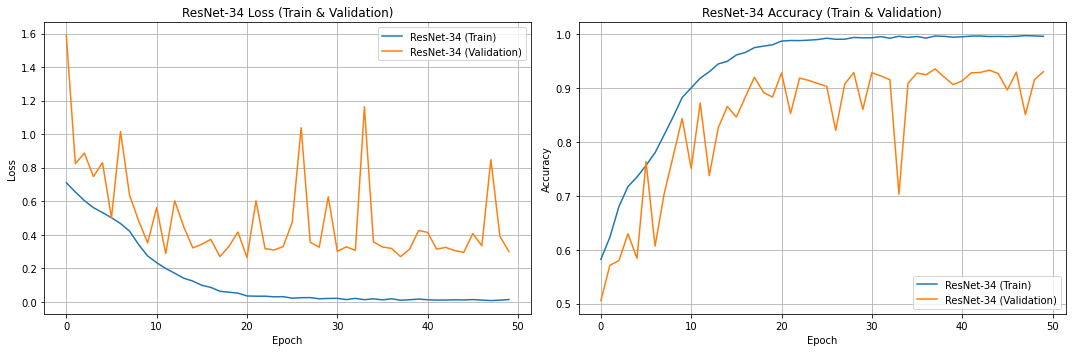

In [37]:
print("\nResNet-34")
plot_metrics(resnet34_history, 'ResNet-34')

In [38]:
resnet_50 = safety_modify_and_compile_model(resnet_50, num_classes)
resnet_50.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 112, 112, 64) 9472        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 112, 112, 64) 256         conv2d_125[0][0]                 
__________________________________________________________________________________________________
re_lu_115 (ReLU)                (None, 112, 112, 64) 0           batch_normalization_125[0][0]    
____________________________________________________________________________________________

In [39]:
print("\nResNet-50 학습 중...")
resnet50_history = resnet_50.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacks
)


ResNet-50 학습 중...
Epoch 1/50
164/582 [=======>......................] - ETA: 2:34 - loss: 0.8708 - accuracy: 0.5715

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.8423 - accuracy: 0.5766

207/582 [=========>....................] - ETA: 2:18 - loss: 0.8365 - accuracy: 0.5773

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.7920 - accuracy: 0.5903

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.7466 - accuracy: 0.5998

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.7439 - accuracy: 0.6020

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.7432 - accuracy: 0.6028

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.7389 - accuracy: 0.6050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.7374 - accuracy: 0.6059

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.6093

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 395ms/step - loss: 0.7302 - accuracy: 0.6093 - val_loss: 1.3039 - val_accuracy: 0.5198
Epoch 2/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.6285 - accuracy: 0.6639

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.6223 - accuracy: 0.6655

207/582 [=========>....................] - ETA: 2:17 - loss: 0.6198 - accuracy: 0.6677

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.6116 - accuracy: 0.6726

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.6038 - accuracy: 0.6802

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.6030 - accuracy: 0.6814

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.6020 - accuracy: 0.6815

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.6012 - accuracy: 0.6827

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.6009 - accuracy: 0.6830

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5990 - accuracy: 0.6858

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.5990 - accuracy: 0.6858 - val_loss: 0.7815 - val_accuracy: 0.5804
Epoch 3/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.5419 - accuracy: 0.7275

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.5491 - accuracy: 0.7210

207/582 [=========>....................] - ETA: 2:17 - loss: 0.5493 - accuracy: 0.7207

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.5564 - accuracy: 0.7200

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.5448 - accuracy: 0.7266

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.5449 - accuracy: 0.7274

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.5447 - accuracy: 0.7277

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.5422 - accuracy: 0.7291

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.5417 - accuracy: 0.7293

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.5400 - accuracy: 0.7299

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 394ms/step - loss: 0.5400 - accuracy: 0.7299 - val_loss: 0.7569 - val_accuracy: 0.6088
Epoch 4/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.5066 - accuracy: 0.7553

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.5098 - accuracy: 0.7521

207/582 [=========>....................] - ETA: 2:17 - loss: 0.5080 - accuracy: 0.7532

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.5011 - accuracy: 0.7585

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.4943 - accuracy: 0.7629

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.4937 - accuracy: 0.7636

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.4926 - accuracy: 0.7642

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.4920 - accuracy: 0.7657

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.4911 - accuracy: 0.7666

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4894 - accuracy: 0.7672

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.4894 - accuracy: 0.7672 - val_loss: 0.8403 - val_accuracy: 0.6126
Epoch 5/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.4480 - accuracy: 0.8022

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.4488 - accuracy: 0.8003

207/582 [=========>....................] - ETA: 2:18 - loss: 0.4482 - accuracy: 0.8007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.4471 - accuracy: 0.7983

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.4377 - accuracy: 0.8017

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.4368 - accuracy: 0.8021

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.4365 - accuracy: 0.8025

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.4398 - accuracy: 0.8007

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.4392 - accuracy: 0.8007

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4429 - accuracy: 0.7993

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.4429 - accuracy: 0.7993 - val_loss: 0.9032 - val_accuracy: 0.6030
Epoch 6/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.4221 - accuracy: 0.8074

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.4183 - accuracy: 0.8076

207/582 [=========>....................] - ETA: 2:17 - loss: 0.4193 - accuracy: 0.8081

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.4172 - accuracy: 0.8125

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.4068 - accuracy: 0.8190

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.4058 - accuracy: 0.8192

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.4065 - accuracy: 0.8188

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.4045 - accuracy: 0.8197

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.4039 - accuracy: 0.8200

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8210

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.4013 - accuracy: 0.8210 - val_loss: 0.5789 - val_accuracy: 0.7046
Epoch 7/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.3654 - accuracy: 0.8356

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.3611 - accuracy: 0.8379

207/582 [=========>....................] - ETA: 2:18 - loss: 0.3600 - accuracy: 0.8389

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.3606 - accuracy: 0.8409

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.3446 - accuracy: 0.8491

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.3442 - accuracy: 0.8494

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.3443 - accuracy: 0.8493

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.3422 - accuracy: 0.8504

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.3417 - accuracy: 0.8508

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3431 - accuracy: 0.8505

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 394ms/step - loss: 0.3431 - accuracy: 0.8505 - val_loss: 0.6211 - val_accuracy: 0.7532
Epoch 8/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.3194 - accuracy: 0.8641

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.3253 - accuracy: 0.8622

207/582 [=========>....................] - ETA: 2:17 - loss: 0.3234 - accuracy: 0.8632

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.3173 - accuracy: 0.8653

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.3103 - accuracy: 0.8688

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.3114 - accuracy: 0.8687

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.3105 - accuracy: 0.8693

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.3083 - accuracy: 0.8699

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.3085 - accuracy: 0.8697

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8704

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 394ms/step - loss: 0.3068 - accuracy: 0.8704 - val_loss: 0.4102 - val_accuracy: 0.8055
Epoch 9/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.2955 - accuracy: 0.8746

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.2922 - accuracy: 0.8772

207/582 [=========>....................] - ETA: 2:17 - loss: 0.2941 - accuracy: 0.8758

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.2892 - accuracy: 0.8782

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.2809 - accuracy: 0.8822

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.2806 - accuracy: 0.8824

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.2794 - accuracy: 0.8831

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.2786 - accuracy: 0.8830

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.2781 - accuracy: 0.8833

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2756 - accuracy: 0.8844

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.2756 - accuracy: 0.8844 - val_loss: 1.1245 - val_accuracy: 0.6866
Epoch 10/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.2516 - accuracy: 0.8944

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.2537 - accuracy: 0.8928

207/582 [=========>....................] - ETA: 2:17 - loss: 0.2530 - accuracy: 0.8930

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.2534 - accuracy: 0.8931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.2414 - accuracy: 0.8983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.2405 - accuracy: 0.8987

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.2389 - accuracy: 0.8994

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.2391 - accuracy: 0.8992

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.2392 - accuracy: 0.8990

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2386 - accuracy: 0.8996

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.2386 - accuracy: 0.8996 - val_loss: 0.3905 - val_accuracy: 0.8298
Epoch 11/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.2224 - accuracy: 0.9095

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.2251 - accuracy: 0.9085

207/582 [=========>....................] - ETA: 2:17 - loss: 0.2243 - accuracy: 0.9084

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.2192 - accuracy: 0.9103

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.2153 - accuracy: 0.9125

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.2144 - accuracy: 0.9128

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.2138 - accuracy: 0.9132

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.2120 - accuracy: 0.9137

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.2126 - accuracy: 0.9135

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2123 - accuracy: 0.9140

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 393ms/step - loss: 0.2123 - accuracy: 0.9140 - val_loss: 0.3878 - val_accuracy: 0.8356
Epoch 12/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.1938 - accuracy: 0.9205

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.1922 - accuracy: 0.9199

207/582 [=========>....................] - ETA: 2:17 - loss: 0.1927 - accuracy: 0.9200

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1928 - accuracy: 0.9201

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1935 - accuracy: 0.9209

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1931 - accuracy: 0.9211

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.1930 - accuracy: 0.9210

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.1929 - accuracy: 0.9209

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.1926 - accuracy: 0.9210

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9217

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.1907 - accuracy: 0.9217 - val_loss: 0.3613 - val_accuracy: 0.8435
Epoch 13/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.1818 - accuracy: 0.9268

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.1823 - accuracy: 0.9272

207/582 [=========>....................] - ETA: 2:17 - loss: 0.1788 - accuracy: 0.9284

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1807 - accuracy: 0.9267

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1772 - accuracy: 0.9288

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1775 - accuracy: 0.9285

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.1782 - accuracy: 0.9279

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.1762 - accuracy: 0.9290

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.1760 - accuracy: 0.9292

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9286

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.1766 - accuracy: 0.9286 - val_loss: 0.4649 - val_accuracy: 0.7618
Epoch 14/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.1555 - accuracy: 0.9367

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.1525 - accuracy: 0.9381

207/582 [=========>....................] - ETA: 2:17 - loss: 0.1524 - accuracy: 0.9386

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1581 - accuracy: 0.9349

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1504 - accuracy: 0.9394

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1500 - accuracy: 0.9396

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.1502 - accuracy: 0.9392

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.1514 - accuracy: 0.9385

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.1518 - accuracy: 0.9384

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1519 - accuracy: 0.9384

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 402ms/step - loss: 0.1519 - accuracy: 0.9384 - val_loss: 0.2751 - val_accuracy: 0.8852
Epoch 15/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.1392 - accuracy: 0.9444

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.1361 - accuracy: 0.9454

207/582 [=========>....................] - ETA: 2:17 - loss: 0.1365 - accuracy: 0.9450

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1404 - accuracy: 0.9427

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1350 - accuracy: 0.9454

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1355 - accuracy: 0.9454

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.1356 - accuracy: 0.9455

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.1353 - accuracy: 0.9455

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.1349 - accuracy: 0.9458

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9447

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.1370 - accuracy: 0.9447 - val_loss: 0.2974 - val_accuracy: 0.8661
Epoch 16/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.1358 - accuracy: 0.9486

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.1336 - accuracy: 0.9491

207/582 [=========>....................] - ETA: 2:17 - loss: 0.1320 - accuracy: 0.9502

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1279 - accuracy: 0.9513

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1249 - accuracy: 0.9505

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1246 - accuracy: 0.9506

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.1238 - accuracy: 0.9511

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.1230 - accuracy: 0.9513

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.1232 - accuracy: 0.9512

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9505

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.1242 - accuracy: 0.9505 - val_loss: 0.4231 - val_accuracy: 0.8106
Epoch 17/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.1250 - accuracy: 0.9487

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.1211 - accuracy: 0.9508

207/582 [=========>....................] - ETA: 2:17 - loss: 0.1194 - accuracy: 0.9520

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1232 - accuracy: 0.9514

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1135 - accuracy: 0.9547

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1137 - accuracy: 0.9544

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.1143 - accuracy: 0.9540

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.1144 - accuracy: 0.9541

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.1141 - accuracy: 0.9543

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9541

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 393ms/step - loss: 0.1145 - accuracy: 0.9541 - val_loss: 0.3080 - val_accuracy: 0.8861
Epoch 18/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0971 - accuracy: 0.9623

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0979 - accuracy: 0.9608

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0988 - accuracy: 0.9607

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1014 - accuracy: 0.9592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1016 - accuracy: 0.9598

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1003 - accuracy: 0.9606

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0997 - accuracy: 0.9607

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0980 - accuracy: 0.9614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0982 - accuracy: 0.9612

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.9604

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.0997 - accuracy: 0.9604 - val_loss: 0.3724 - val_accuracy: 0.8424
Epoch 19/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.1002 - accuracy: 0.9611

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.1011 - accuracy: 0.9602

207/582 [=========>....................] - ETA: 2:17 - loss: 0.1011 - accuracy: 0.9603

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0973 - accuracy: 0.9617

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0891 - accuracy: 0.9645

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0885 - accuracy: 0.9647

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0887 - accuracy: 0.9645

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0875 - accuracy: 0.9651

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0875 - accuracy: 0.9651

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9652

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0877 - accuracy: 0.9652 - val_loss: 0.4243 - val_accuracy: 0.8098
Epoch 20/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0908 - accuracy: 0.9682

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0900 - accuracy: 0.9689

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0895 - accuracy: 0.9688

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0879 - accuracy: 0.9689

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0845 - accuracy: 0.9696

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0844 - accuracy: 0.9694

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0837 - accuracy: 0.9697

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0831 - accuracy: 0.9697

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0827 - accuracy: 0.9698

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9699

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.0827 - accuracy: 0.9699 - val_loss: 0.2920 - val_accuracy: 0.9108
Epoch 21/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0794 - accuracy: 0.9701

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0780 - accuracy: 0.9703

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0777 - accuracy: 0.9704

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0748 - accuracy: 0.9719

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0720 - accuracy: 0.9722

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0721 - accuracy: 0.9721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0721 - accuracy: 0.9721

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0723 - accuracy: 0.9716

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0726 - accuracy: 0.9716

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9708

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0738 - accuracy: 0.9708 - val_loss: 0.2256 - val_accuracy: 0.9089
Epoch 22/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0637 - accuracy: 0.9747

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0626 - accuracy: 0.9751

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0626 - accuracy: 0.9751

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0677 - accuracy: 0.9732

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0624 - accuracy: 0.9760

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0622 - accuracy: 0.9761

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0621 - accuracy: 0.9763

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0619 - accuracy: 0.9765

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0618 - accuracy: 0.9765

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9768

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 402ms/step - loss: 0.0606 - accuracy: 0.9768 - val_loss: 0.2970 - val_accuracy: 0.9039
Epoch 23/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0507 - accuracy: 0.9806

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0531 - accuracy: 0.9792

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0530 - accuracy: 0.9790

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0586 - accuracy: 0.9772

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0572 - accuracy: 0.9776

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0570 - accuracy: 0.9778

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0573 - accuracy: 0.9775

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0588 - accuracy: 0.9771

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0593 - accuracy: 0.9767

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9769

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 401ms/step - loss: 0.0592 - accuracy: 0.9769 - val_loss: 0.3269 - val_accuracy: 0.8831
Epoch 24/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0664 - accuracy: 0.9739

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0666 - accuracy: 0.9741

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0657 - accuracy: 0.9745

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0639 - accuracy: 0.9748

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0513 - accuracy: 0.9800

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0510 - accuracy: 0.9802

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0509 - accuracy: 0.9802

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0508 - accuracy: 0.9804

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0511 - accuracy: 0.9802

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9804

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.0499 - accuracy: 0.9804 - val_loss: 0.3130 - val_accuracy: 0.9089
Epoch 25/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0625 - accuracy: 0.9739

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0601 - accuracy: 0.9751

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0595 - accuracy: 0.9754

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0584 - accuracy: 0.9766

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0515 - accuracy: 0.9806

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0521 - accuracy: 0.9806

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0520 - accuracy: 0.9806

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0515 - accuracy: 0.9805

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0521 - accuracy: 0.9804

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9808

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0511 - accuracy: 0.9808 - val_loss: 0.2544 - val_accuracy: 0.9192
Epoch 26/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0362 - accuracy: 0.9872

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0448 - accuracy: 0.9846

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0531 - accuracy: 0.9819

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.1214 - accuracy: 0.9556

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.1168 - accuracy: 0.9573

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.1152 - accuracy: 0.9579

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.1142 - accuracy: 0.9583

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.1115 - accuracy: 0.9590

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.1108 - accuracy: 0.9594

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1063 - accuracy: 0.9609

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 402ms/step - loss: 0.1063 - accuracy: 0.9609 - val_loss: 0.2395 - val_accuracy: 0.9196
Epoch 27/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0463 - accuracy: 0.9825

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0428 - accuracy: 0.9841

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0431 - accuracy: 0.9838

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0459 - accuracy: 0.9838

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0409 - accuracy: 0.9852

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0403 - accuracy: 0.9855

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0398 - accuracy: 0.9858

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0387 - accuracy: 0.9863

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0383 - accuracy: 0.9864

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9864

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0383 - accuracy: 0.9864 - val_loss: 0.2731 - val_accuracy: 0.9286
Epoch 28/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0321 - accuracy: 0.9889

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0325 - accuracy: 0.9883

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0317 - accuracy: 0.9885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0370 - accuracy: 0.9863

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0383 - accuracy: 0.9857

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0377 - accuracy: 0.9859

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0373 - accuracy: 0.9861

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0370 - accuracy: 0.9861

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0367 - accuracy: 0.9863

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9865

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 402ms/step - loss: 0.0363 - accuracy: 0.9865 - val_loss: 0.2528 - val_accuracy: 0.9250
Epoch 29/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0529 - accuracy: 0.9808

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0479 - accuracy: 0.9824

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0465 - accuracy: 0.9828

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0453 - accuracy: 0.9829

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0405 - accuracy: 0.9848

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0400 - accuracy: 0.9848

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0394 - accuracy: 0.9850

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0391 - accuracy: 0.9852

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0388 - accuracy: 0.9854

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9859

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.0374 - accuracy: 0.9859 - val_loss: 0.2825 - val_accuracy: 0.9181
Epoch 30/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0288 - accuracy: 0.9897

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0303 - accuracy: 0.9886

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0302 - accuracy: 0.9885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0316 - accuracy: 0.9882

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0358 - accuracy: 0.9871

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0355 - accuracy: 0.9873

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0354 - accuracy: 0.9874

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0350 - accuracy: 0.9875

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0349 - accuracy: 0.9875

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9878

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0338 - accuracy: 0.9878 - val_loss: 0.3722 - val_accuracy: 0.9129
Epoch 31/50
164/582 [=======>......................] - ETA: 2:32 - loss: 0.0303 - accuracy: 0.9903

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:20 - loss: 0.0285 - accuracy: 0.9910

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0279 - accuracy: 0.9909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:50 - loss: 0.0277 - accuracy: 0.9906

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0282 - accuracy: 0.9899

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0282 - accuracy: 0.9899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0279 - accuracy: 0.9901

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0284 - accuracy: 0.9898

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0288 - accuracy: 0.9897

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9889

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0322 - accuracy: 0.9889 - val_loss: 0.3827 - val_accuracy: 0.8536
Epoch 32/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0470 - accuracy: 0.9823

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0428 - accuracy: 0.9837

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0416 - accuracy: 0.9841

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0369 - accuracy: 0.9862

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0304 - accuracy: 0.9885

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0299 - accuracy: 0.9887

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0296 - accuracy: 0.9889

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0285 - accuracy: 0.9893

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0286 - accuracy: 0.9892

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9887

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 234s 401ms/step - loss: 0.0302 - accuracy: 0.9887 - val_loss: 0.5488 - val_accuracy: 0.8755
Epoch 33/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0433 - accuracy: 0.9853

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0391 - accuracy: 0.9867

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0386 - accuracy: 0.9867

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0342 - accuracy: 0.9881

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0291 - accuracy: 0.9897

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0289 - accuracy: 0.9899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0292 - accuracy: 0.9897

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0292 - accuracy: 0.9897

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0291 - accuracy: 0.9896

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9896

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0289 - accuracy: 0.9896 - val_loss: 0.3303 - val_accuracy: 0.9181
Epoch 34/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0321 - accuracy: 0.9880

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0337 - accuracy: 0.9879

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0326 - accuracy: 0.9884

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0340 - accuracy: 0.9870

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0286 - accuracy: 0.9893

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0280 - accuracy: 0.9896

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0278 - accuracy: 0.9897

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0275 - accuracy: 0.9897

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0274 - accuracy: 0.9898

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9899

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0267 - accuracy: 0.9899 - val_loss: 0.3167 - val_accuracy: 0.9267
Epoch 35/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0342 - accuracy: 0.9882

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0319 - accuracy: 0.9887

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0322 - accuracy: 0.9885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0327 - accuracy: 0.9887

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0285 - accuracy: 0.9905

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0281 - accuracy: 0.9907

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0280 - accuracy: 0.9907

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0283 - accuracy: 0.9904

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0282 - accuracy: 0.9904

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0297 - accuracy: 0.9899

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0297 - accuracy: 0.9899 - val_loss: 0.6980 - val_accuracy: 0.8403
Epoch 36/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0297 - accuracy: 0.9895

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0264 - accuracy: 0.9908

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0260 - accuracy: 0.9909

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0288 - accuracy: 0.9897

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0239 - accuracy: 0.9920

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0235 - accuracy: 0.9921

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0231 - accuracy: 0.9922

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0225 - accuracy: 0.9924

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0224 - accuracy: 0.9925

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9922

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0226 - accuracy: 0.9922 - val_loss: 0.3287 - val_accuracy: 0.9256
Epoch 37/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0403 - accuracy: 0.9851

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0376 - accuracy: 0.9857

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0371 - accuracy: 0.9860

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0316 - accuracy: 0.9880

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0335 - accuracy: 0.9876

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0336 - accuracy: 0.9876

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0337 - accuracy: 0.9875

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0339 - accuracy: 0.9877

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0338 - accuracy: 0.9876

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9876

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0341 - accuracy: 0.9876 - val_loss: 1.6278 - val_accuracy: 0.8386
Epoch 38/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0344 - accuracy: 0.9880

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0324 - accuracy: 0.9881

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0320 - accuracy: 0.9882

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0292 - accuracy: 0.9892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0240 - accuracy: 0.9910

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0237 - accuracy: 0.9912

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0234 - accuracy: 0.9913

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0228 - accuracy: 0.9915

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0226 - accuracy: 0.9916

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9919

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0217 - accuracy: 0.9919 - val_loss: 0.3150 - val_accuracy: 0.9243
Epoch 39/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0239 - accuracy: 0.9912

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0274 - accuracy: 0.9902

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0281 - accuracy: 0.9896

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0316 - accuracy: 0.9888

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0259 - accuracy: 0.9907

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0260 - accuracy: 0.9908

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0259 - accuracy: 0.9908

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0274 - accuracy: 0.9905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0272 - accuracy: 0.9906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9906

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 401ms/step - loss: 0.0273 - accuracy: 0.9906 - val_loss: 0.2823 - val_accuracy: 0.9233
Epoch 40/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0157 - accuracy: 0.9943

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0154 - accuracy: 0.9949

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0150 - accuracy: 0.9950

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0167 - accuracy: 0.9945

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0167 - accuracy: 0.9945

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0164 - accuracy: 0.9946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0161 - accuracy: 0.9947

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0157 - accuracy: 0.9948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0155 - accuracy: 0.9949

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9951

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.2528 - val_accuracy: 0.9390
Epoch 41/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0112 - accuracy: 0.9958

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0121 - accuracy: 0.9956

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0119 - accuracy: 0.9956

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0109 - accuracy: 0.9960

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0116 - accuracy: 0.9960

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0122 - accuracy: 0.9956

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0129 - accuracy: 0.9953

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0166 - accuracy: 0.9942

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0168 - accuracy: 0.9940

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0185 - accuracy: 0.9934 - val_loss: 0.3964 - val_accuracy: 0.9076
Epoch 42/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0222 - accuracy: 0.9928

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0212 - accuracy: 0.9927

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0208 - accuracy: 0.9929

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0200 - accuracy: 0.9931

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0188 - accuracy: 0.9932

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0187 - accuracy: 0.9933

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0184 - accuracy: 0.9934

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0186 - accuracy: 0.9933

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0184 - accuracy: 0.9933

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 235s 402ms/step - loss: 0.0184 - accuracy: 0.9932 - val_loss: 0.2509 - val_accuracy: 0.9355
Epoch 43/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0193 - accuracy: 0.9933

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0233 - accuracy: 0.9924

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0240 - accuracy: 0.9915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0233 - accuracy: 0.9918

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0225 - accuracy: 0.9920

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0223 - accuracy: 0.9920

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0222 - accuracy: 0.9921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0219 - accuracy: 0.9923

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0219 - accuracy: 0.9922

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9925

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0214 - accuracy: 0.9925 - val_loss: 0.2194 - val_accuracy: 0.9394
Epoch 44/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0308 - accuracy: 0.9895

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0281 - accuracy: 0.9905

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0270 - accuracy: 0.9908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0249 - accuracy: 0.9913

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0216 - accuracy: 0.9924

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0213 - accuracy: 0.9924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0211 - accuracy: 0.9925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0202 - accuracy: 0.9929

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0200 - accuracy: 0.9929

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9933

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 392ms/step - loss: 0.0190 - accuracy: 0.9933 - val_loss: 0.2418 - val_accuracy: 0.9402
Epoch 45/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0264 - accuracy: 0.9916

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0236 - accuracy: 0.9924

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0232 - accuracy: 0.9925

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0195 - accuracy: 0.9936

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0164 - accuracy: 0.9946

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0164 - accuracy: 0.9946

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0174 - accuracy: 0.9943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0175 - accuracy: 0.9943

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0184 - accuracy: 0.9941 - val_loss: 0.3973 - val_accuracy: 0.8955
Epoch 46/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0317 - accuracy: 0.9897

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0276 - accuracy: 0.9911

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0264 - accuracy: 0.9915

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0218 - accuracy: 0.9934

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0202 - accuracy: 0.9936

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0200 - accuracy: 0.9936

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0202 - accuracy: 0.9936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0212 - accuracy: 0.9933

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0211 - accuracy: 0.9933

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9935

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 230s 393ms/step - loss: 0.0205 - accuracy: 0.9935 - val_loss: 0.2718 - val_accuracy: 0.9321
Epoch 47/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0168 - accuracy: 0.9941

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0159 - accuracy: 0.9943

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0155 - accuracy: 0.9944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:50 - loss: 0.0148 - accuracy: 0.9947

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0210 - accuracy: 0.9927

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0208 - accuracy: 0.9929

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0205 - accuracy: 0.9930

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0203 - accuracy: 0.9931

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0204 - accuracy: 0.9931

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9932

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0202 - accuracy: 0.9932 - val_loss: 0.2519 - val_accuracy: 0.9334
Epoch 48/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0206 - accuracy: 0.9916

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0217 - accuracy: 0.9916

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0216 - accuracy: 0.9912

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0222 - accuracy: 0.9905

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0188 - accuracy: 0.9922

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0184 - accuracy: 0.9924

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0181 - accuracy: 0.9925

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0178 - accuracy: 0.9927

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0178 - accuracy: 0.9928

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9925

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0185 - accuracy: 0.9925 - val_loss: 0.2601 - val_accuracy: 0.9340
Epoch 49/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0085 - accuracy: 0.9973

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0084 - accuracy: 0.9971

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0083 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0080 - accuracy: 0.9974

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0095 - accuracy: 0.9967

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0095 - accuracy: 0.9967

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 26s - loss: 0.0096 - accuracy: 0.9966

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0094 - accuracy: 0.9966

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0095 - accuracy: 0.9966

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9966

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 392ms/step - loss: 0.0095 - accuracy: 0.9966 - val_loss: 0.5183 - val_accuracy: 0.8938
Epoch 50/50
164/582 [=======>......................] - ETA: 2:33 - loss: 0.0096 - accuracy: 0.9970

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:21 - loss: 0.0087 - accuracy: 0.9971

207/582 [=========>....................] - ETA: 2:17 - loss: 0.0084 - accuracy: 0.9973

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:51 - loss: 0.0108 - accuracy: 0.9966

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 34s - loss: 0.0164 - accuracy: 0.9944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 30s - loss: 0.0164 - accuracy: 0.9944

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 25s - loss: 0.0163 - accuracy: 0.9944

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 16s - loss: 0.0159 - accuracy: 0.9946

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 13s - loss: 0.0157 - accuracy: 0.9947

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9948

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 229s 391ms/step - loss: 0.0153 - accuracy: 0.9948 - val_loss: 0.2994 - val_accuracy: 0.9284



ResNet-50


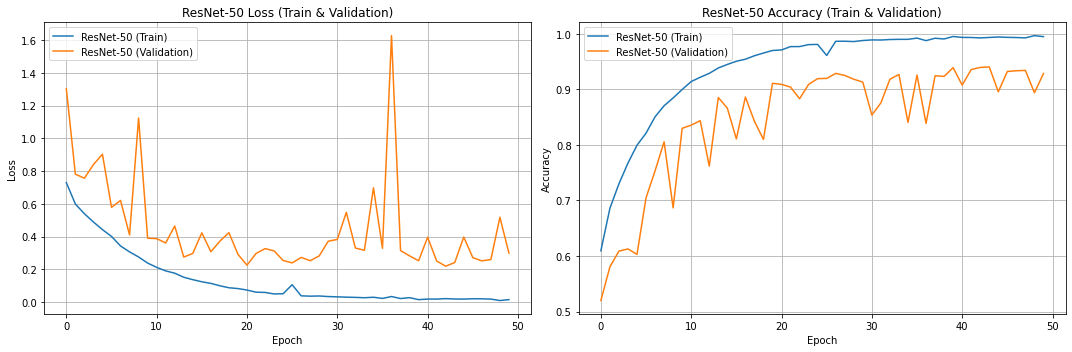

In [40]:
print("\nResNet-50")
plot_metrics(resnet50_history, 'ResNet-50')

### 시각화  

학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

In [41]:
def compare_models(history1, history2, model1_name, model2_name):
    """두 모델의 검증 손실과 정확도 비교"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 검증 손실 그래프
    ax1.plot(history1.history['val_loss'], label=model1_name)
    ax1.plot(history2.history['val_loss'], label=model2_name)
    ax1.set_title('Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 검증 정확도 그래프
    ax2.plot(history1.history['val_accuracy'], label=model1_name)
    ax2.plot(history2.history['val_accuracy'], label=model2_name)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

### 결과 비교


ResNet-34 vs ResNet-50 비교


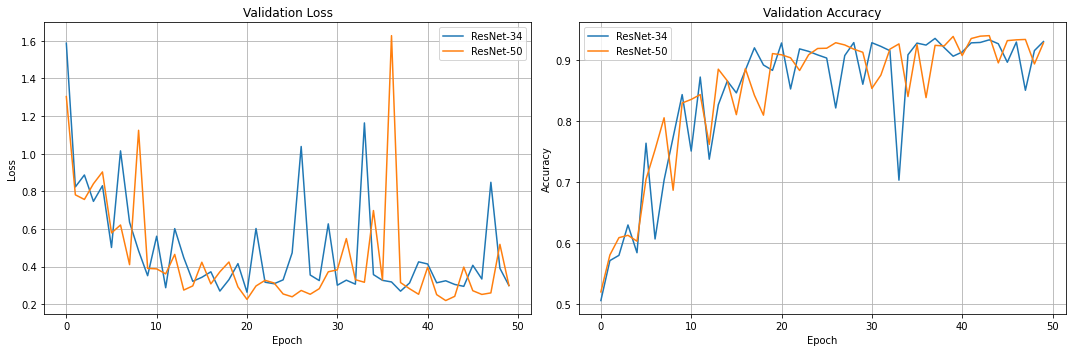

In [42]:
print("\nResNet-34 vs ResNet-50 비교")
compare_models(resnet34_history, resnet50_history, 'ResNet-34', 'ResNet-50')


ResNet-34 vs PlainNet-34 비교


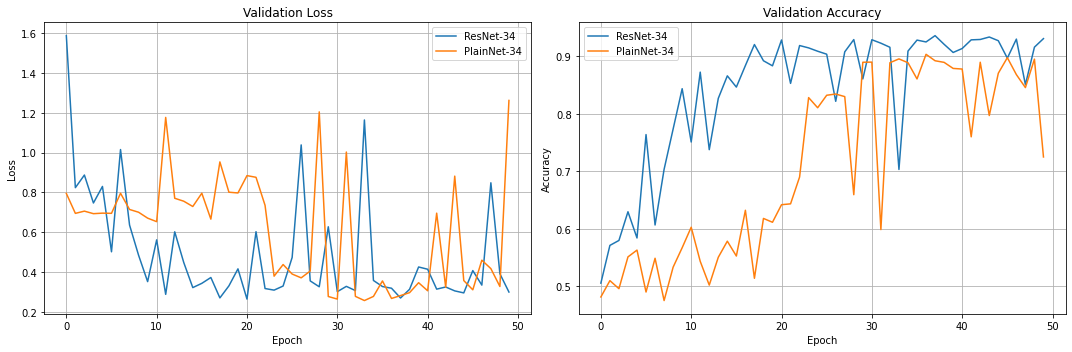

In [43]:
print("\nResNet-34 vs PlainNet-34 비교")
compare_models(resnet34_history, plainnet34_history, 'ResNet-34', 'PlainNet-34')


ResNet-50 vs PlainNet-50 비교


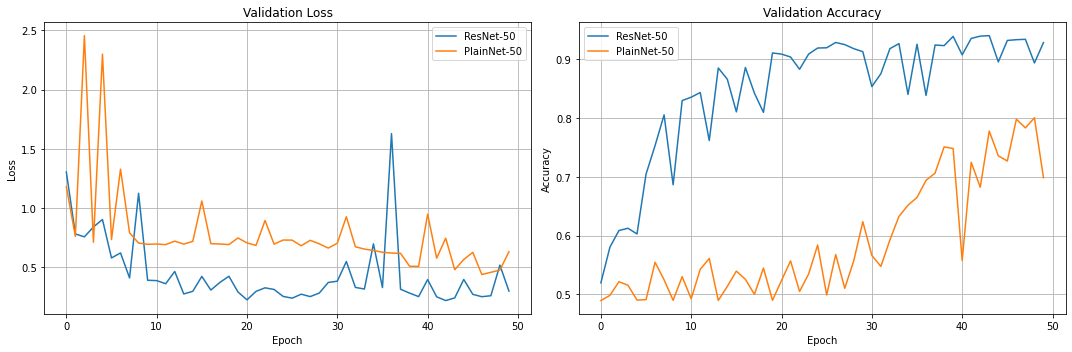

In [44]:
print("\nResNet-50 vs PlainNet-50 비교")
compare_models(resnet50_history, plainnet50_history, 'ResNet-50', 'PlainNet-50')

In [45]:
def create_comparison_tables(resnet34_history, resnet50_history,
                           plainnet34_history, plainnet50_history):
    """세 가지 비교표 생성: ResNet-34 vs 50, ResNet vs PlainNet (34), ResNet vs PlainNet (50)"""

    # 각 모델의 최고 validation accuracy
    accuracies = {
        'ResNet-34': max(resnet34_history.history['val_accuracy']) * 100,
        'ResNet-50': max(resnet50_history.history['val_accuracy']) * 100,
        'PlainNet-34': max(plainnet34_history.history['val_accuracy']) * 100,
        'PlainNet-50': max(plainnet50_history.history['val_accuracy']) * 100
    }

    # 1. ResNet-34 vs ResNet-50
    print("\nResNet Depth Comparison - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'ResNet-34':<15} {accuracies['ResNet-34']:>15.2f}")
    print(f"{'ResNet-50':<15} {accuracies['ResNet-50']:>15.2f}")
    print("-" * 40)

    # 2. ResNet-34 vs PlainNet-34
    print("\nResNet-34 vs PlainNet-34 - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'ResNet-34':<15} {accuracies['ResNet-34']:>15.2f}")
    print(f"{'PlainNet-34':<15} {accuracies['PlainNet-34']:>15.2f}")
    print("-" * 40)

    # 3. ResNet-50 vs PlainNet-50
    print("\nResNet-50 vs PlainNet-50 - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'ResNet-50':<15} {accuracies['ResNet-50']:>15.2f}")
    print(f"{'PlainNet-50':<15} {accuracies['PlainNet-50']:>15.2f}")
    print("-" * 40)

In [46]:
# 결과표 생성
create_comparison_tables(resnet34_history, resnet50_history,
                        plainnet34_history, plainnet50_history)


ResNet Depth Comparison - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
ResNet-34                 93.57
ResNet-50                 94.02
----------------------------------------

ResNet-34 vs PlainNet-34 - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
ResNet-34                 93.57
PlainNet-34               90.33
----------------------------------------

ResNet-50 vs PlainNet-50 - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
ResNet-50                 94.02
PlainNet-50               80.05
----------------------------------------


### 회고
- 백본 모델을 항상 가져다 쓰다가 직접 구현 하려고 보니 많이 어려웠다. 기조가 아직 부족하다.
- 그림을 그려가며 머리속에 좀 더 구조화 시키는 연습이 필요 할 거 같다.
- 시간상 EPOCH 10 으로 설정 하였으나 결과 그래프가 예상과는 많이 차이가 났다.
- 피어 리뷰 후 epoch 수를 늘려서 다시 테스트 할 예정이다.
- LMS 상에서 cats_vs_dogs 다운로드 문제가 colab 에서는 발생 하지 않았는데 tensorflow 버전 차이로 보인다.
- 데이터셋 중에 손상된 이미지가 있는 것으로 보인다. 다행히 colab 로그를 보면 자동으로 그런 이미지는 제외하고 다운로드 받는다고 한다.
- 결과를 보면 ResNet-50 Accuracy 가 ResNet-34 보다 낮게 나왔는데 오버피팅 영향으로 보인다.  
- PlainNet-34 와 비교해 보면 근소하게 ResNet-34 가 높게 나왔는데 이 부분도 학습을 충분히 시키면 그 차이가 더 생기지 않을까?  
- PlainNet-50 와 비교해 보면 ResNet-50 의 Accuracy 가 더 낮게 나왔다. 이 부분은 이해가 잘 안되는 결과라 디버깅이 필요 할 거 같다.

### 추가 실험에서 확인 할 수 있었던 사항들
---

### PlainNet-50 과 ResNet-50 비교 실험에서 확실히 레이어가 깊어 질 수록 skip connection 효과가 있다!

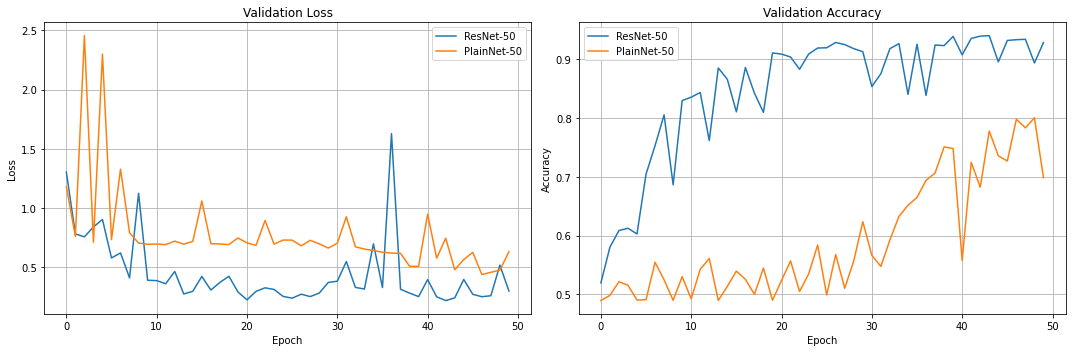

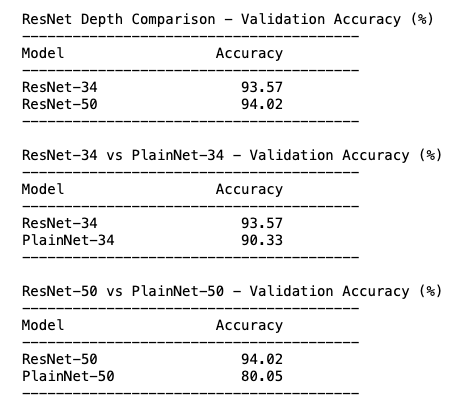

- epoch 을 50 으로 늘려 테스트 해본 결과 성능에서 ResNet-50 이 높게 나왔다.
- epoch 이 10 일 때 ResNet-50 Accuracy 가 ResNet-34 보다 낮게 나왔던건 오버피팅 영향이 아니라 학습이 충분치 않아서였다.
- 결론적으로 10번의 epoch 으로는 학습 추이를 보기에는 너무 짧았고 loss 가 한번씩 크게 튀는 현상이 있었는데 이는 local minima 에서 빠져 나오는 현상이 아닐까 생각 된다.
- 비교 실험에서 확실히 레이어가 깊어 질 수록 skip connection 효과가 있다는 걸 확인 할 수 있었다.
- PlainNet-50 의 성능이 가장 떨어졌는데 레이어가 깊다고 성능이 좋은게 아니란걸 확인 할 수 있었다. 

### 실험 진행 예정 사항
- tensorflow 에서 제공되는 ResNet50 을 사용하여 직접 구현한 코드와 비교

In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# 기본 ResNet50 모델 불러오기
base_model = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))

# 모든 층 학습 가능하도록 설정
for layer in base_model.layers:
    layer.trainable = True

# 새로운 분류층 추가
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(2048, activation='relu')(x)
predictions = layers.Dense(2)(x)

# 최종 모델 생성
tf_ResNet50_model = Model(inputs=base_model.input, outputs=predictions)
tf_ResNet50_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [49]:
tf_ResNet50_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [50]:
print("\ntensorflow ResNet50 학습 중...")
tf_ResNet50_history = tf_ResNet50_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacksb
)


tensorflow ResNet50 학습 중...
Epoch 1/50
164/582 [=======>......................] - ETA: 2:17 - loss: 0.4611 - accuracy: 0.8260

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:06 - loss: 0.4218 - accuracy: 0.8391

207/582 [=========>....................] - ETA: 2:03 - loss: 0.4128 - accuracy: 0.8427

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:39 - loss: 0.3564 - accuracy: 0.8632

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 31s - loss: 0.2760 - accuracy: 0.8923

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.2742 - accuracy: 0.8932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 23s - loss: 0.2702 - accuracy: 0.8948

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.2627 - accuracy: 0.8974

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.2615 - accuracy: 0.8980

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.2531 - accuracy: 0.9015

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 211s 352ms/step - loss: 0.2531 - accuracy: 0.9015 - val_loss: 1.3532 - val_accuracy: 0.4914
Epoch 2/50
164/582 [=======>......................] - ETA: 2:16 - loss: 0.1430 - accuracy: 0.9461

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:06 - loss: 0.1390 - accuracy: 0.9475

207/582 [=========>....................] - ETA: 2:02 - loss: 0.1361 - accuracy: 0.9487

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:39 - loss: 0.1316 - accuracy: 0.9500

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 31s - loss: 0.1319 - accuracy: 0.9488

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1319 - accuracy: 0.9488

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 23s - loss: 0.1320 - accuracy: 0.9485

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1311 - accuracy: 0.9487

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1313 - accuracy: 0.9486

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1306 - accuracy: 0.9489

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 205s 350ms/step - loss: 0.1306 - accuracy: 0.9489 - val_loss: 0.5442 - val_accuracy: 0.7580
Epoch 3/50
164/582 [=======>......................] - ETA: 2:16 - loss: 0.1271 - accuracy: 0.9474

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:05 - loss: 0.1312 - accuracy: 0.9470

207/582 [=========>....................] - ETA: 2:02 - loss: 0.1306 - accuracy: 0.9470

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:38 - loss: 0.1222 - accuracy: 0.9504

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 31s - loss: 0.1190 - accuracy: 0.9522

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1178 - accuracy: 0.9525

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 23s - loss: 0.1167 - accuracy: 0.9531

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1163 - accuracy: 0.9536

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1167 - accuracy: 0.9535

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1145 - accuracy: 0.9546

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 205s 350ms/step - loss: 0.1145 - accuracy: 0.9546 - val_loss: 0.2352 - val_accuracy: 0.8975
Epoch 4/50
164/582 [=======>......................] - ETA: 2:17 - loss: 0.1117 - accuracy: 0.9564

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:06 - loss: 0.1078 - accuracy: 0.9573

207/582 [=========>....................] - ETA: 2:02 - loss: 0.1077 - accuracy: 0.9571

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:39 - loss: 0.1104 - accuracy: 0.9560

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


487/582 [========================>.....] - ETA: 31s - loss: 0.1052 - accuracy: 0.9591

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


500/582 [========================>.....] - ETA: 26s - loss: 0.1065 - accuracy: 0.9584

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


511/582 [=========================>....] - ETA: 23s - loss: 0.1064 - accuracy: 0.9584

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


538/582 [==========================>...] - ETA: 14s - loss: 0.1063 - accuracy: 0.9588

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


544/582 [===========================>..] - ETA: 12s - loss: 0.1059 - accuracy: 0.9590

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


582/582 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9588

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


582/582 [==============================] - 205s 350ms/step - loss: 0.1059 - accuracy: 0.9588 - val_loss: 0.2254 - val_accuracy: 0.9069
Epoch 5/50
164/582 [=======>......................] - ETA: 2:16 - loss: 0.1027 - accuracy: 0.9619

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


197/582 [=========>....................] - ETA: 2:05 - loss: 0.1039 - accuracy: 0.9600

207/582 [=========>....................] - ETA: 2:02 - loss: 0.1047 - accuracy: 0.9589

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


279/582 [=============>................] - ETA: 1:38 - loss: 0.0982 - accuracy: 0.9609

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


304/582 [==============>...............] - ETA: 1:30 - loss: 0.0959 - accuracy: 0.9617

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import ResNet34

# 기본 ResNet34 모델 불러오기
base_model = ResNet34(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3))

# 모든 층 학습 가능하도록 설정
for layer in base_model.layers:
    layer.trainable = True

# 새로운 분류층 추가
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(2)(x)

# 최종 모델 생성
tf_ResNet34_model = Model(inputs=base_model.input, outputs=predictions)
tf_ResNet34_model.summary()

In [ ]:
tf_ResNet34_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [ ]:
print("\ntensorflow ResNet34 학습 중...")
tf_ResNet34_history = tf_ResNet34_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacksb
)